# Data Preparation

## Load data from sqlite3 in json

In [1]:
from utils.db.get_data_db import get_data_json
## accuracy
from utils.information_retrieval import get_times_per_tt, get_confidence_per_tt, get_answers_scores_MCO, get_answers_scores_SCO
from utils.models import get_inference_SCO_LA1,get_inference_MCO_LA1, get_inference_SCO_LA2,get_inference_MCO_LA2#, get_inference_multi_conf, get_inference_sinlg_part, get_inference_categ
##
from utils.models import get_times_inference_LA1, get_times_inference_LA2, get_confidence_inference_LA1, get_confidence_inference_LA2

import numpy as np

import warnings
warnings.filterwarnings('ignore')

db_file_path = 'data/study_02.db'
data = get_data_json(db_file_path)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data cleaning

Remove any incomplete registration created when participants by mistake clicked multiple times the "Registration" button.

In [2]:
data_processed = {}
for p in data:
    if data[p]['status'] == "end" or data[  p]['status'] == "end_thanks":
        data_processed[p] = data[p]

## Get observed Response Times, Accuracy, and Confidence per Task Type (TT) and group (IG, SG, AG)

<!-- There are 3 research questions in the study. -->

TT1: Does interaction help users to identify the existence or not of (strong) relations among probabilistic models’ parameters 

TT2: Does interaction help users to identify the type of relation of model’s parameters and/or predictions 

----------------------

IG: Interaction Group

SG: Static Group

AG: Animation Group

<!-- The study consisted of 3 problems. Each problem was modelled by a different probabilistic model. There were 3 sets of questions in each problem with every set corresponding to one of the research questions. -->

<!-- The task ids per problem and RQ are following:

**Problem 1: Temperature in Scotland**

RQ1: t1

RQ2: t2, t3, t4

RQ3: t5

**Problem 2: Random real-number generator**

RQ1: t6

RQ2: t7, t8, t9

RQ3: t10, t11

**Problem 3: Lorry drivers reaction times**

RQ1: t12, t13

RQ2: t14, t15, t16, t17

RQ3: t18, t19 -->

In [3]:
# task ids per TT
t_ids = {}
t_ids['T1'] = ['t1','t2','t3','t4','t5','t6','t7','t8','t9','t10']
t_ids['T2'] = ['t11','t12','t13','t14','t15','t16']

## times
times_i, times_s, times_a = get_times_per_tt(data_processed, t_ids, db_file_path) # returns Dict <TT: Dict<t_id:List>>
## confidence
conf_i, conf_s, conf_a = get_confidence_per_tt(data_processed, t_ids, db_file_path) # returns Dict <TT: Dict<t_id:List>>

## TT1
## corr answ taken responses as multiple choice selections
answ_sc_i_multi, answ_sc_s_multi, answ_sc_a_multi = get_answers_scores_MCO(data_processed, 
                                                                                                 t_ids['T1'], 
                                                                                                 db_file_path, 'T1') # returns Dict<t_id:List>
## corr answ taken responses as single selection
answ_sc_i_singl, answ_sc_s_singl, answ_sc_a_singl = get_answers_scores_SCO(data_processed, 
                                                                                               t_ids['T1'], 
                                                                                               db_file_path) # returns Dict<t_id:List>
## TT2
answ_sc_i_model_T2, answ_sc_s_model_T2, answ_sc_a_model_T2 = get_answers_scores_SCO(data_processed, 
                                                                                               t_ids['T2'], 
                                                                                               db_file_path) # returns Dict<t_id:List>
answ_sc_i_interv_T2, answ_sc_s_interv_T2, answ_sc_a_interv_T2 = get_answers_scores_MCO(data_processed, 
                                                                                                 t_ids['T2'], 
                                                                                                 db_file_path, 'T2') # returns Dict<t_id:List>

## get only responses to interventions from participants who got the model correct
answ_sc_i_interv_corr_mod_T2 = {'t11':[],'t12':[],'t13':[],'t14':[],'t15':[],'t16':[]}
for t in answ_sc_i_model_T2:
    for i,v in enumerate(answ_sc_i_model_T2[t]):
        if v:
            answ_sc_i_interv_corr_mod_T2[t].append(answ_sc_i_interv_T2[t][i])
answ_sc_s_interv_corr_mod_T2 = {'t11':[],'t12':[],'t13':[],'t14':[],'t15':[],'t16':[]}
for t in answ_sc_s_model_T2:
    for i,v in enumerate(answ_sc_s_model_T2[t]):
        if v:
            answ_sc_s_interv_corr_mod_T2[t].append(answ_sc_s_interv_T2[t][i])
answ_sc_a_interv_corr_mod_T2 = {'t11':[],'t12':[],'t13':[],'t14':[],'t15':[],'t16':[]}
for t in answ_sc_a_model_T2:
    for i,v in enumerate(answ_sc_a_model_T2[t]):
        if v:
            answ_sc_a_interv_corr_mod_T2[t].append(answ_sc_a_interv_T2[t][i])

# TT1
## Single Correct Option (SCO) - LA1

Takes participants together independently of the visualization condition.

Accuracy: 

0  If participant selects a wrong option from the 3 available

1  If participant selects the correct option from the 3 available

In [5]:
## Analysis taking answers as a single option
## Responses in IG, SG, AG
ans_i = [j for _,value in answ_sc_i_singl.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_singl.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_singl.items() 
         for j in value]
ans = ans_i+ans_s+ans_a
## task indeces 
t_indices_i = [t_ids['T1'].index(t)
               for t,value in answ_sc_i_singl.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t)
               for t,value in answ_sc_s_singl.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_singl.items() 
               for j in value]
t_indices = t_indices_i+t_indices_s+t_indices_a
## extension for 'all'
for t,value in answ_sc_i_singl.items():
    for j in value:
        t_indices.append(10)
for t,value in answ_sc_s_singl.items():
    for j in value:
        t_indices.append(10)
for t,value in answ_sc_a_singl.items():
    for j in value:
        t_indices.append(10)
#
for _,value in answ_sc_i_singl.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_singl.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_singl.items(): 
    for j in value:
        ans.append(j)
## extension for 'atomic', 'shift', 'variance'
t_atomic = ['t1','t2','t3','t4','t5']
t_shift = ['t6','t7']
t_variance = ['t8','t9','t10']
for t,value in answ_sc_i_singl.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13) 
for t,value in answ_sc_s_singl.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13) 
for t,value in answ_sc_a_singl.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13)
#
for _,value in answ_sc_i_singl.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_singl.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_singl.items(): 
    for j in value:
        ans.append(j)
##        
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
t_id.append('atomic')
t_id.append('shift')
t_id.append('variance')
trace_acc_T1_sco_m1, pp_acc_T1_sco_m1 = get_inference_SCO_LA1(ans,
                                                        t_indices, 
                                                        t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


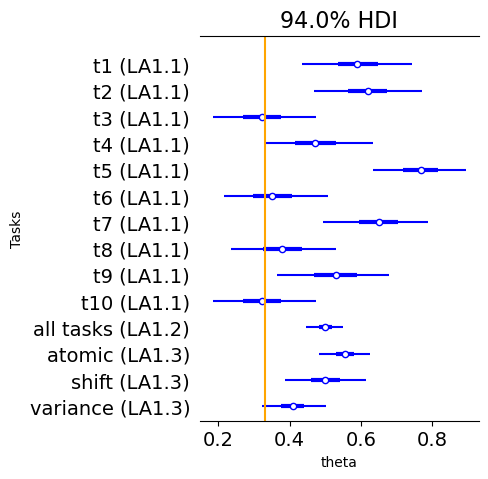

In [9]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_acc_T1_sco_m1)
prob = 0.94
az.plot_forest(ai['posterior']['theta'], ax = ax, combined = True, hdi_prob = prob, colors = 'blue')
ax.vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['variance (LA1.3)','shift (LA1.3)','atomic (LA1.3)','all tasks (LA1.2)','t10 (LA1.1)','t9 (LA1.1)','t8 (LA1.1)','t7 (LA1.1)','t6 (LA1.1)','t5 (LA1.1)','t4 (LA1.1)','t3 (LA1.1)','t2 (LA1.1)','t1 (LA1.1)'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("theta")
plt.savefig('ch6_Fig10_a.svg',dpi=300)

## Single Correct Option (SCO) - LA2 

Takes participants together based on visualization condition

Accuracy: 

0  If participant selects a wrong option from the 3 available

1  If participant selects the correct option from the 3 available

In [10]:
## Analysis taking answers as a single option
## Responses in IG, SG, AG
ans_i = [j for _,value in answ_sc_i_singl.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_singl.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_singl.items() 
         for j in value]
## task indeces 
t_indices_i = [t_ids['T1'].index(t)
               for t,value in answ_sc_i_singl.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t)
               for t,value in answ_sc_s_singl.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_singl.items() 
               for j in value]
## extension for 'all'
for t,value in answ_sc_i_singl.items():
    for j in value:
        t_indices_i.append(10)
for t,value in answ_sc_s_singl.items():
    for j in value:
        t_indices_s.append(10)
for t,value in answ_sc_a_singl.items():
    for j in value:
        t_indices_a.append(10)
#
for _,value in answ_sc_i_singl.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_singl.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_singl.items(): 
    for j in value:
        ans_a.append(j)
# ## extension for 'atomic', 'shift', 'variance'
# t_atomic = ['t1','t2','t3','t4','t5']
# t_shift = ['t6','t7']
# t_variance = ['t8','t9','t10']
# for t,value in answ_sc_i_singl.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_i.append(11)
#         elif t in t_shift:
#             t_indices_i.append(12)
#         elif t in t_variance:
#             t_indices_i.append(13) 
# for t,value in answ_sc_s_singl.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_s.append(11)
#         elif t in t_shift:
#             t_indices_s.append(12)
#         elif t in t_variance:
#             t_indices_s.append(13) 
# for t,value in answ_sc_a_singl.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_a.append(11)
#         elif t in t_shift:
#             t_indices_a.append(12)
#         elif t in t_variance:
#             t_indices_a.append(13)
# #
# for _,value in answ_sc_i_singl.items(): 
#     for j in value:
#         ans_i.append(j)
# for _,value in answ_sc_s_singl.items():
#     for j in value:
#         ans_s.append(j)
# for _,value in answ_sc_a_singl.items(): 
#     for j in value:
#         ans_a.append(j)
##        
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
# t_id.append('atomic')
# t_id.append('shift')
# t_id.append('variance')
trace_acc_T1_sc0_m2, pp_acc_T1_sc0_m2 = get_inference_SCO_LA2(ans_i, 
                                                        ans_s,
                                                        ans_a,
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_indices_a, 
                                                        t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


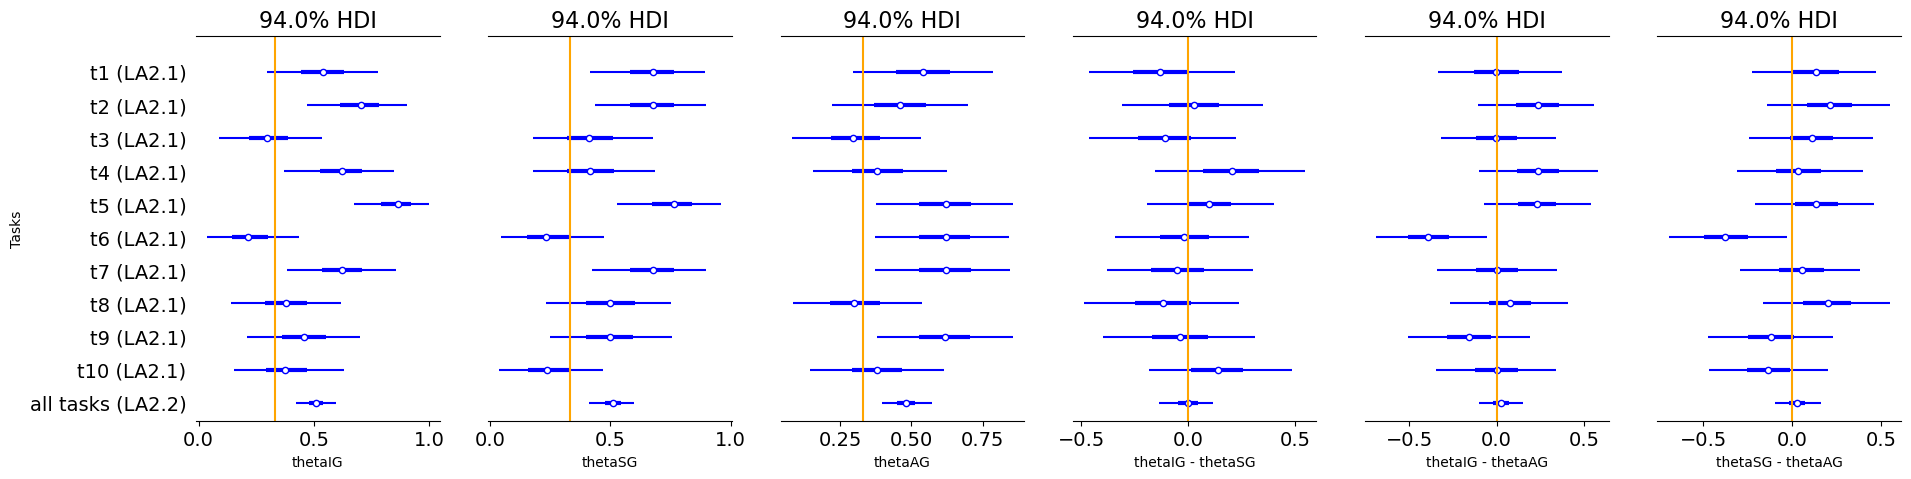

In [12]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T1_sc0_m2)
prob = 0.94
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True, hdi_prob = prob, colors = 'blue')
ax[0].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True, hdi_prob = prob, colors = 'blue')
ax[1].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True, hdi_prob = prob, colors = 'blue')
ax[2].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True, hdi_prob = prob, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True, hdi_prob = prob, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True, hdi_prob = prob, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
ax[0].set_yticklabels(['all tasks (LA2.2)','t10 (LA2.1)','t9 (LA2.1)','t8 (LA2.1)','t7 (LA2.1)','t6 (LA2.1)','t5 (LA2.1)','t4 (LA2.1)','t3 (LA2.1)','t2 (LA2.1)','t1 (LA2.1)'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("thetaIG - thetaSG")
ax[4].set_xlabel("thetaIG - thetaAG")
ax[5].set_xlabel("thetaSG - thetaAG")
plt.savefig('ch6_Fig10_b.svg',dpi=300)

## Multiple Correct Options (MCO) - LA1 

Takes participants together independently of visualization condition.

Accuracy: 

0  If hamming score = 0 (0 digits in the digital representations of correct answer and participant's response are similar)

1  If hamming score = 1

2  If hamming score = 2

In [55]:
## number of trials (available options) per task in TT1
n_i = [2
       for t,value in answ_sc_i_multi.items() 
       for j in value]
n_s = [2
       for t,value in answ_sc_s_multi.items() 
       for j in value]
n_a = [2
       for t,value in answ_sc_a_multi.items() 
       for j in value]
n = n_i+n_s+n_a
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_multi.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_multi.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_multi.items() 
         for j in value]
ans = ans_i+ans_s+ans_a
## indices 
t_indices_i = [t_ids['T1'].index(t) 
               for t,value in answ_sc_i_multi.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t) 
               for t,value in answ_sc_s_multi.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_multi.items() 
               for j in value]
t_indices = t_indices_i+t_indices_s+t_indices_a
## extension for 'all'
for i in range(len(n_i)):
    n.append(2)
for i in range(len(n_s)):
    n.append(2)
for i in range(len(n_a)):
    n.append(2)
#
for t,value in answ_sc_i_multi.items():
    for j in value:
        t_indices.append(10)
for t,value in answ_sc_s_multi.items():
    for j in value:
        t_indices.append(10)
for t,value in answ_sc_a_multi.items():
    for j in value:
        t_indices.append(10)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans.append(j)
## extension for 'atomic', 'shift', 'variance'
for t,value in answ_sc_i_multi.items(): 
    for j in value:
        n.append(2)
for t,value in answ_sc_s_multi.items(): 
    for j in value:
        n.append(2)
for t,value in answ_sc_a_multi.items(): 
    for j in value:
        n.append(2)
#
t_atomic = ['t1','t2','t3','t4','t5']
t_shift = ['t6','t7']
t_variance = ['t8','t9','t10']
for t,value in answ_sc_i_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13)
for t,value in answ_sc_s_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13)
for t,value in answ_sc_a_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(11)
        elif t in t_shift:
            t_indices.append(12)
        elif t in t_variance:
            t_indices.append(13)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans.append(j)
##
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
t_id.append('atomic')
t_id.append('shift')
t_id.append('variance')
trace_acc_T1_mco_m1, pp_acc_T1_mco_m1 = get_inference_MCO_LA1(ans,
                                                n, 
                                                t_indices,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


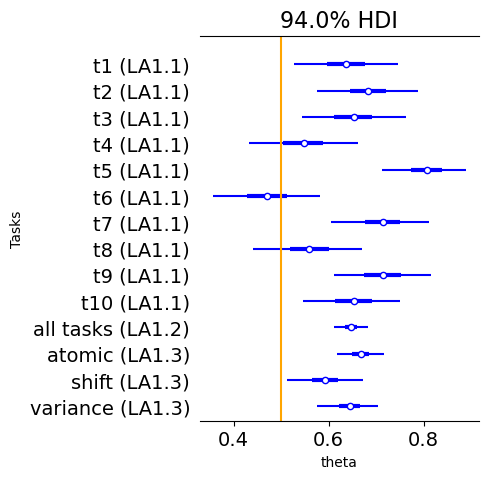

In [56]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_acc_T1_mco_m1)
prob = 0.94
az.plot_forest(ai['posterior']['theta'], ax = ax, combined = True, hdi_prob = prob, colors = 'blue')
ax.vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['variance (LA1.3)','shift (LA1.3)','atomic (LA1.3)','all tasks (LA1.2)','t10 (LA1.1)','t9 (LA1.1)','t8 (LA1.1)','t7 (LA1.1)','t6 (LA1.1)','t5 (LA1.1)','t4 (LA1.1)','t3 (LA1.1)','t2 (LA1.1)','t1 (LA1.1)'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("theta")
plt.savefig('ch6_Fig10_c.svg',dpi=300)

## Multiple Correct Options (MCO) Model 2 

Takes participants together based on visualization condition.

Accuracy: 

0  If hamming score = 0 (0 digits in the digital representations of correct answer and participant's response are similar)

1  If hamming score = 1

2  If hamming score = 2

In [15]:
## number of trials (available options) per task in TT1
n_i = [2
       for t,value in answ_sc_i_multi.items() 
       for j in value]
n_s = [2
       for t,value in answ_sc_s_multi.items() 
       for j in value]
n_a = [2
       for t,value in answ_sc_a_multi.items() 
       for j in value]
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_multi.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_multi.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_multi.items() 
         for j in value]
## indices 
t_indices_i = [t_ids['T1'].index(t) 
               for t,value in answ_sc_i_multi.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t) 
               for t,value in answ_sc_s_multi.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_multi.items() 
               for j in value]
## extension for 'all'
for i in range(len(n_i)):
    n_i.append(2)
for i in range(len(n_s)):
    n_s.append(2)
for i in range(len(n_a)):
    n_a.append(2)
#
for t,value in answ_sc_i_multi.items():
    for j in value:
        t_indices_i.append(10)
for t,value in answ_sc_s_multi.items():
    for j in value:
        t_indices_s.append(10)
for t,value in answ_sc_a_multi.items():
    for j in value:
        t_indices_a.append(10)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans_a.append(j)
# ## extension for 'atomic', 'shift', 'variance'
# for t,value in answ_sc_i_multi.items(): 
#     for j in value:
#         n_i.append(2)
# for t,value in answ_sc_s_multi.items(): 
#     for j in value:
#         n_s.append(2)
# for t,value in answ_sc_a_multi.items(): 
#     for j in value:
#         n_a.append(2)
# #
# t_atomic = ['t1','t2','t3','t4','t5']
# t_shift = ['t6','t7']
# t_variance = ['t8','t9','t10']
# for t,value in answ_sc_i_multi.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_i.append(11)
#         elif t in t_shift:
#             t_indices_i.append(12)
#         elif t in t_variance:
#             t_indices_i.append(13)
# for t,value in answ_sc_s_multi.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_s.append(11)
#         elif t in t_shift:
#             t_indices_s.append(12)
#         elif t in t_variance:
#             t_indices_s.append(13)
# for t,value in answ_sc_a_multi.items():
#     for j in value:
#         if t in t_atomic:
#             t_indices_a.append(11)
#         elif t in t_shift:
#             t_indices_a.append(12)
#         elif t in t_variance:
#             t_indices_a.append(13)
# #
# for _,value in answ_sc_i_multi.items(): 
#     for j in value:
#         ans_i.append(j)
# for _,value in answ_sc_s_multi.items():
#     for j in value:
#         ans_s.append(j)
# for _,value in answ_sc_a_multi.items(): 
#     for j in value:
#         ans_a.append(j)
#
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
# t_id.append('atomic')
# t_id.append('shift')
# t_id.append('variance')
trace_acc_T1_mco_m2, pp_acc_T1_mco_m2 = get_inference_MCO_LA2(ans_i, ans_s, ans_a,
                                                n_i, n_s, n_a, 
                                                t_indices_i, t_indices_s, t_indices_a,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


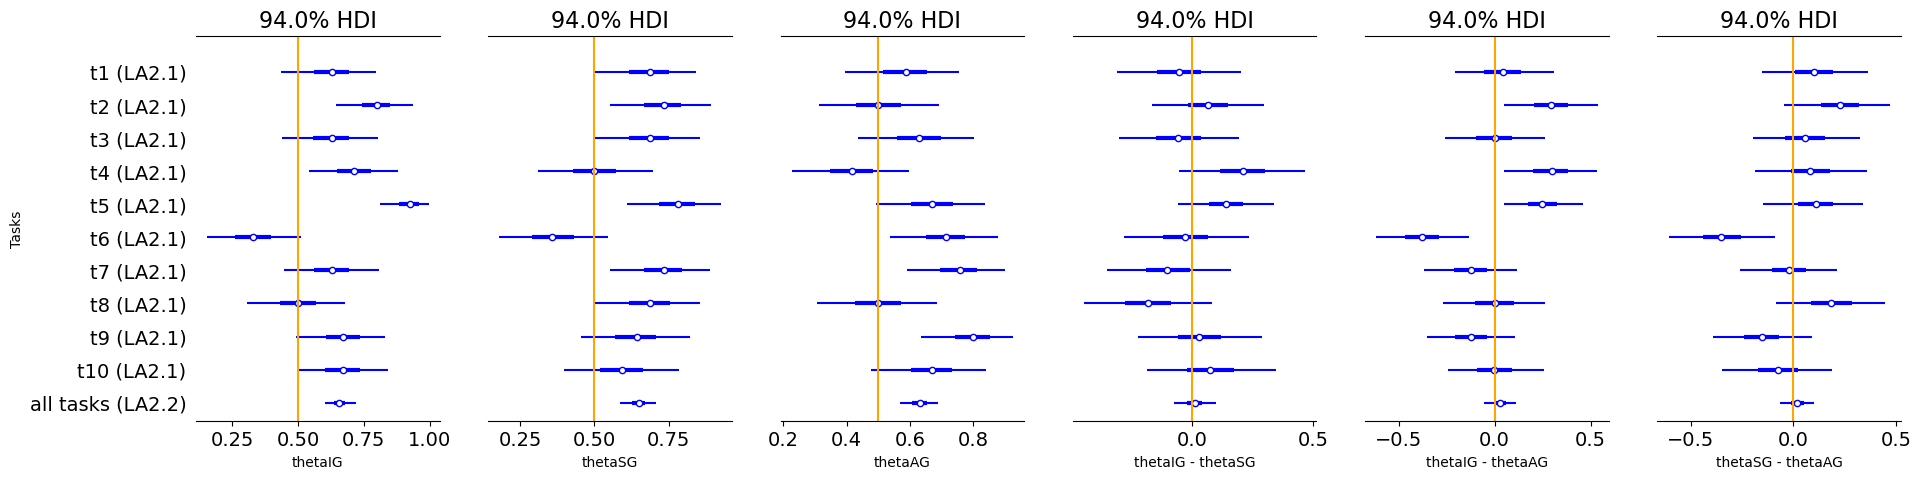

In [16]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T1_mco_m2)
prob = 0.94
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True, hdi_prob = prob, colors = 'blue')
ax[0].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True, hdi_prob = prob, colors = 'blue')
ax[1].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True, hdi_prob = prob, colors = 'blue')
ax[2].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True, hdi_prob = prob, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True, hdi_prob = prob, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True, hdi_prob = prob, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
ax[0].set_yticklabels(['all tasks (LA2.2)','t10 (LA2.1)','t9 (LA2.1)','t8 (LA2.1)','t7 (LA2.1)','t6 (LA2.1)','t5 (LA2.1)','t4 (LA2.1)','t3 (LA2.1)','t2 (LA2.1)','t1 (LA2.1)'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("thetaIG - thetaSG")
ax[4].set_xlabel("thetaIG - thetaAG")
ax[5].set_xlabel("thetaSG - thetaAG")
plt.savefig('ch6_Fig10_d.svg',dpi=300)

# TT2
## Single Correct Option (SCO) - LA1
Model Decision

Taking all participants independently of the visualization mode.

Acc: 

0  If participant selects a wrong option from the 3 available

1  If participant selects the correct option from the 3 available

In [6]:
## Analysis taking answers as a single option
# interactive, static, and animated answers
ans_i = [j for _,value in answ_sc_i_model_T2.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_model_T2.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_model_T2.items() 
         for j in value]
ans = ans_i+ans_s+ans_a
#indices 
t_indices_i = [t_ids['T2'].index(t) 
               for t,value in answ_sc_i_model_T2.items() 
               for j in value]
t_indices_s = [t_ids['T2'].index(t) 
               for t,value in answ_sc_s_model_T2.items() 
               for j in value]
t_indices_a = [t_ids['T2'].index(t) 
               for t,value in answ_sc_a_model_T2.items() 
               for j in value]
t_indices = t_indices_i+t_indices_s+t_indices_a
## extension for 'all'
for t,value in answ_sc_i_model_T2.items():
    for j in value:
        t_indices.append(6)
for t,value in answ_sc_s_model_T2.items():
    for j in value:
        t_indices.append(6)
for t,value in answ_sc_a_model_T2.items():
    for j in value:
        t_indices.append(6)
#
for _,value in answ_sc_i_model_T2.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_model_T2.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_model_T2.items(): 
    for j in value:
        ans.append(j)
## extension for 'atomic', 'shift', 'variance'
t_atomic = ['t11','t12']
t_shift = ['t13','t14']
t_variance = ['t15','t16']
for t,value in answ_sc_i_model_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9) 
for t,value in answ_sc_s_model_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9) 
for t,value in answ_sc_a_model_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
#
for _,value in answ_sc_i_model_T2.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_model_T2.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_model_T2.items(): 
    for j in value:
        ans.append(j)
##
t_id = []
t_id.extend(t_ids['T2'])
t_id.append('all tasks')
t_id.append('atomic')
t_id.append('shift')
t_id.append('variance')
trace_acc_T2_sco_m1, pp_acc_T2_sco_m1 = get_inference_SCO_LA1(ans,
                                                        t_indices, 
                                                        t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


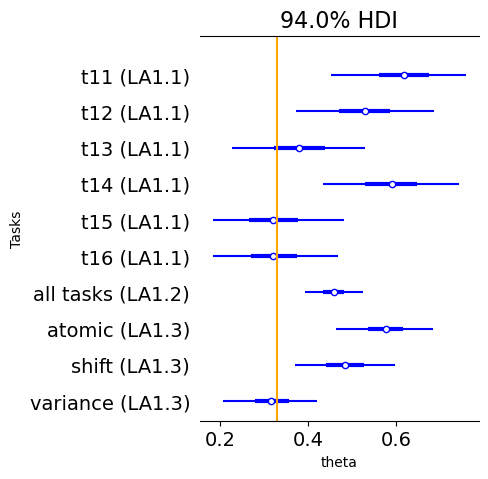

In [7]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_acc_T2_sco_m1)
prob = 0.94
az.plot_forest(ai['posterior']['theta'], ax = ax, combined = True, hdi_prob = prob, colors = 'blue')
ax.vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['variance (LA1.3)','shift (LA1.3)','atomic (LA1.3)','all tasks (LA1.2)','t16 (LA1.1)','t15 (LA1.1)','t14 (LA1.1)','t13 (LA1.1)','t12 (LA1.1)','t11 (LA1.1)'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("theta")
plt.savefig('ch6_Fig11_a.svg',dpi=300)

## Single Correct Option (SCO) - LA2
Model Decision

Taking all participants based on the visualization mode.

Acc: 

0  If participant selects a wrong option from the 3 available

1  If participant selects the correct option from the 3 available

In [5]:
## Analysis taking answers as a single option
# interactive, static, and animated answers
ans_i = [j for _,value in answ_sc_i_model_T2.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_model_T2.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_model_T2.items() 
         for j in value]
#indices 
t_indices_i = [t_ids['T2'].index(t) 
               for t,value in answ_sc_i_model_T2.items() 
               for j in value]
t_indices_s = [t_ids['T2'].index(t) 
               for t,value in answ_sc_s_model_T2.items() 
               for j in value]
t_indices_a = [t_ids['T2'].index(t) 
               for t,value in answ_sc_a_model_T2.items() 
               for j in value]
## extension for 'all'
for t,value in answ_sc_i_model_T2.items():
    for j in value:
        t_indices_i.append(6)
for t,value in answ_sc_s_model_T2.items():
    for j in value:
        t_indices_s.append(6)
for t,value in answ_sc_a_model_T2.items():
    for j in value:
        t_indices_a.append(6)
#
for _,value in answ_sc_i_model_T2.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_model_T2.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_model_T2.items(): 
    for j in value:
        ans_a.append(j)
t_id = []
t_id.extend(t_ids['T2'])
t_id.append('all tasks')
trace_acc_T2_sco_m2, pp_acc_T2_sco_m2 = get_inference_SCO_LA2(ans_i, 
                                                        ans_s,
                                                        ans_a,
                                                        t_indices_i, 
                                                        t_indices_s, 
                                                        t_indices_a, 
                                                        t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


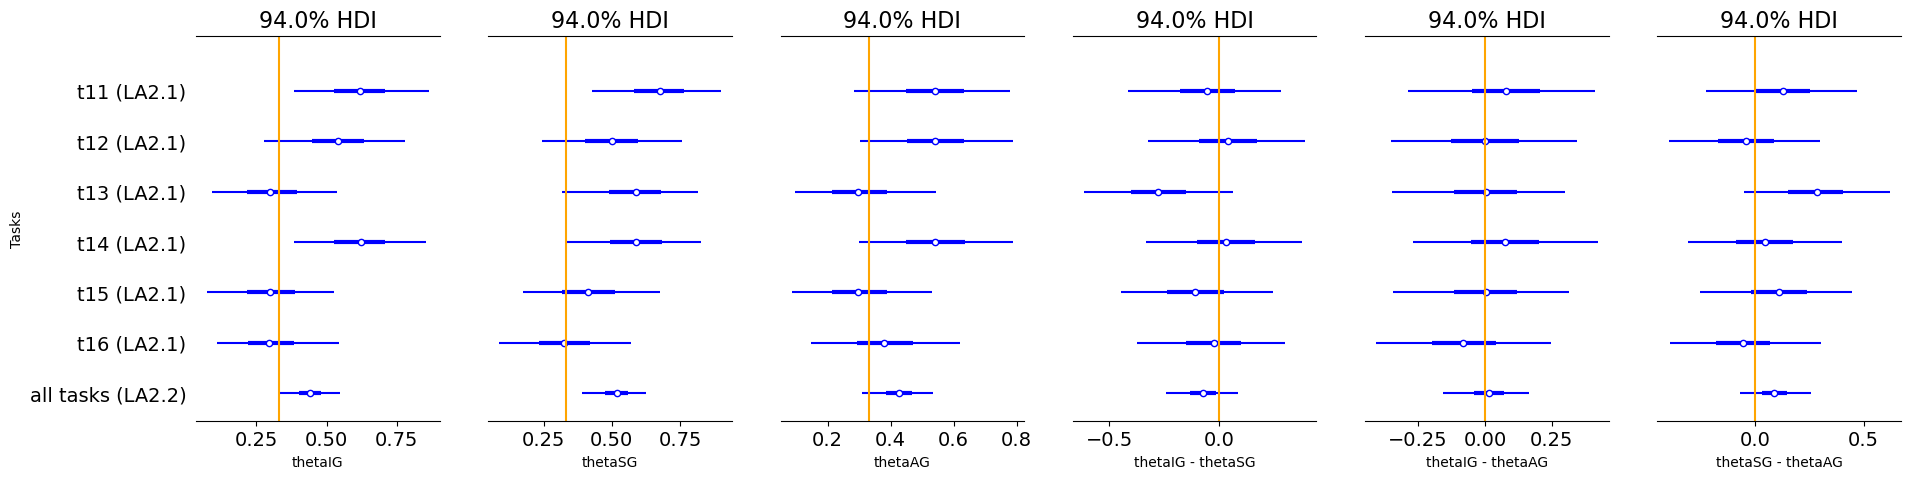

In [6]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T2_sco_m2)
# ai['posterior']
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True, colors = 'blue')
ax[0].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True, colors = 'blue')
ax[1].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True, colors = 'blue')
ax[2].vlines(x = 0.33, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
ax[0].set_yticklabels(['all tasks (LA2.2)','t16 (LA2.1)','t15 (LA2.1)','t14 (LA2.1)','t13 (LA2.1)','t12 (LA2.1)','t11 (LA2.1)'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("thetaIG - thetaSG")
ax[4].set_xlabel("thetaIG - thetaAG")
ax[5].set_xlabel("thetaSG - thetaAG")
plt.savefig('ch6_Fig11_b.svg', dpi=300)

## Multiple Correct Options (MCO) - LA1 

Takes participants together independently of visualization condition.

Accuracy: 

0  If hamming score = 0 (0 digits in the digital representations of correct answer and participant's response are similar)

1  If hamming score = 1

2  If hamming score = 2

In [53]:
## number of trials (available options) per task in TT1
n_i = [3
       for t,value in answ_sc_i_interv_T2.items() 
       for j in value]
n_s = [3
       for t,value in answ_sc_s_interv_T2.items() 
       for j in value]
n_a = [3
       for t,value in answ_sc_a_interv_T2.items() 
       for j in value]
n = n_i+n_s+n_a
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_interv_T2.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_interv_T2.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_interv_T2.items() 
         for j in value]
ans = ans_i+ans_s+ans_a
## indices 
t_indices_i = [t_ids['T2'].index(t) 
               for t,value in answ_sc_i_interv_T2.items() 
               for j in value]
t_indices_s = [t_ids['T2'].index(t) 
               for t,value in answ_sc_s_interv_T2.items() 
               for j in value]
t_indices_a = [t_ids['T2'].index(t) 
               for t,value in answ_sc_a_interv_T2.items() 
               for j in value]
t_indices = t_indices_i+t_indices_s+t_indices_a
## extension for 'all'
for i in range(len(n_i)):
    n.append(3)
for i in range(len(n_s)):
    n.append(3)
for i in range(len(n_a)):
    n.append(3)
#
for t,value in answ_sc_i_interv_T2.items():
    for j in value:
        t_indices.append(6)
for t,value in answ_sc_s_interv_T2.items():
    for j in value:
        t_indices.append(6)
for t,value in answ_sc_a_interv_T2.items():
    for j in value:
        t_indices.append(6)
#
for _,value in answ_sc_i_interv_T2.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_interv_T2.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_interv_T2.items(): 
    for j in value:
        ans.append(j)
## extension for 'atomic', 'shift', 'variance'
for t,value in answ_sc_i_interv_T2.items(): 
    for j in value:
        n.append(3)
for t,value in answ_sc_s_interv_T2.items(): 
    for j in value:
        n.append(3)
for t,value in answ_sc_a_interv_T2.items(): 
    for j in value:
        n.append(3)
#
t_atomic = ['t11','t12']
t_shift = ['t13','t14']
t_variance = ['t15','t16']
for t,value in answ_sc_i_interv_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
for t,value in answ_sc_s_interv_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
for t,value in answ_sc_a_interv_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
#
for _,value in answ_sc_i_interv_T2.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_interv_T2.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_interv_T2.items(): 
    for j in value:
        ans.append(j)
##
t_id = []
t_id.extend(t_ids['T2'])
t_id.append('all')
t_id.append('atomic')
t_id.append('shift')
t_id.append('variance')
trace_acc_T2_mco_m1, pp_acc_T2_mco_m1 = get_inference_MCO_LA1(ans,
                                                n, 
                                                t_indices,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


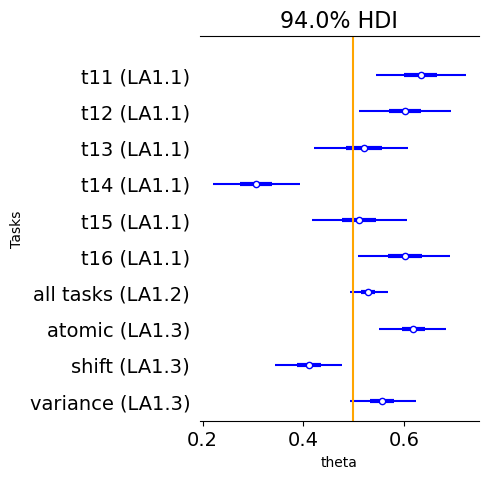

In [54]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_acc_T2_mco_m1)
prob = 0.94
az.plot_forest(ai['posterior']['theta'], ax = ax, combined = True, hdi_prob = prob, colors = 'blue')
ax.vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['variance (LA1.3)','shift (LA1.3)','atomic (LA1.3)','all tasks (LA1.2)','t16 (LA1.1)','t15 (LA1.1)','t14 (LA1.1)','t13 (LA1.1)','t12 (LA1.1)','t11 (LA1.1)'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("theta")
plt.savefig('ch6_Fig11_c.svg',dpi=300)

## Multiple Correct Options (MCO) LA2 

Takes all participants together based on visualization condition.

Accuracy: 

0  If hamming score = 0 (0 digits in the digital representations of correct answer and participant's response are similar)

1  If hamming score = 1

2  If hamming score = 2

In [7]:
## number of trials (available options) per task in TT1
n_i = [3
       for t,value in answ_sc_i_interv_T2.items() 
       for j in value]
n_s = [3
       for t,value in answ_sc_s_interv_T2.items() 
       for j in value]
n_a = [3
       for t,value in answ_sc_a_interv_T2.items() 
       for j in value]
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_interv_T2.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_interv_T2.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_interv_T2.items() 
         for j in value]
## indices 
t_indices_i = [t_ids['T2'].index(t) 
               for t,value in answ_sc_i_interv_T2.items() 
               for j in value]
t_indices_s = [t_ids['T2'].index(t) 
               for t,value in answ_sc_s_interv_T2.items() 
               for j in value]
t_indices_a = [t_ids['T2'].index(t) 
               for t,value in answ_sc_a_interv_T2.items() 
               for j in value]
## extension for 'all'
for i in range(len(n_i)):
    n_i.append(3)
for i in range(len(n_s)):
    n_s.append(3)
for i in range(len(n_a)):
    n_a.append(3)
#
for t,value in answ_sc_i_interv_T2.items():
    for j in value:
        t_indices_i.append(6)
for t,value in answ_sc_s_interv_T2.items():
    for j in value:
        t_indices_s.append(6)
for t,value in answ_sc_a_interv_T2.items():
    for j in value:
        t_indices_a.append(6)
#
for _,value in answ_sc_i_interv_T2.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_interv_T2.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_interv_T2.items(): 
    for j in value:
        ans_a.append(j)
#
t_id = []
t_id.extend(t_ids['T2'])
t_id.append('all')
trace_acc_T2_mco_m2, pp_acc_T2_mco_m2 = get_inference_MCO_LA2(ans_i, ans_s, ans_a,
                                                n_i, n_s, n_a, 
                                                t_indices_i, t_indices_s, t_indices_a,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


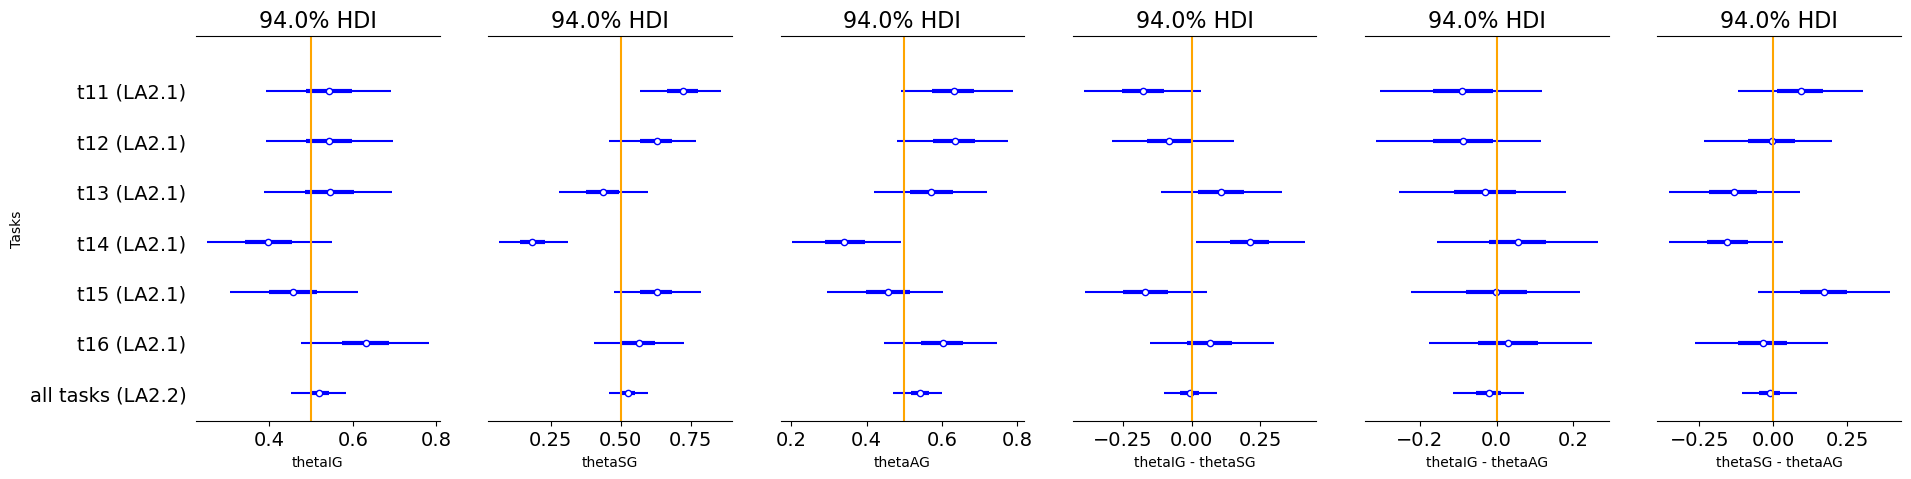

In [8]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T2_mco_m2)
prob = 0.94
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True, hdi_prob = prob, colors = 'blue')
ax[0].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True, hdi_prob = prob, colors = 'blue')
ax[1].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True, hdi_prob = prob, colors = 'blue')
ax[2].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True, hdi_prob = prob, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True, hdi_prob = prob, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True, hdi_prob = prob, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
ax[0].set_yticklabels(['all tasks (LA2.2)','t16 (LA2.1)','t15 (LA2.1)','t14 (LA2.1)','t13 (LA2.1)','t12 (LA2.1)','t11 (LA2.1)'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("thetaIG - thetaSG")
ax[4].set_xlabel("thetaIG - thetaAG")
ax[5].set_xlabel("thetaSG - thetaAG")
plt.savefig('ch6_Fig11_d.svg',dpi=300)

## Multiple Correct Options (MCO) - LA1 

Takes **only** participants who got the model correct together independently of visualization condition.

Accuracy: 

0  If hamming score = 0 (0 digits in the digital representations of correct answer and participant's response are similar)

1  If hamming score = 1

2  If hamming score = 2

In [51]:
## number of trials (available options) per task in TT1
n_i = [3
       for t,value in answ_sc_i_interv_corr_mod_T2.items() 
       for j in value]
n_s = [3
       for t,value in answ_sc_s_interv_corr_mod_T2.items() 
       for j in value]
n_a = [3
       for t,value in answ_sc_a_interv_corr_mod_T2.items() 
       for j in value]
n = n_i+n_s+n_a
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_interv_corr_mod_T2.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_interv_corr_mod_T2.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_interv_corr_mod_T2.items() 
         for j in value]
ans = ans_i+ans_s+ans_a
## indices 
t_indices_i = [t_ids['T2'].index(t) 
               for t,value in answ_sc_i_interv_corr_mod_T2.items() 
               for j in value]
t_indices_s = [t_ids['T2'].index(t) 
               for t,value in answ_sc_s_interv_corr_mod_T2.items() 
               for j in value]
t_indices_a = [t_ids['T2'].index(t) 
               for t,value in answ_sc_a_interv_corr_mod_T2.items() 
               for j in value]
t_indices = t_indices_i+t_indices_s+t_indices_a
## extension for 'all'
for i in range(len(n_i)):
    n.append(3)
for i in range(len(n_s)):
    n.append(3)
for i in range(len(n_a)):
    n.append(3)
#
for t,value in answ_sc_i_interv_corr_mod_T2.items():
    for j in value:
        t_indices.append(6)
for t,value in answ_sc_s_interv_corr_mod_T2.items():
    for j in value:
        t_indices.append(6)
for t,value in answ_sc_a_interv_corr_mod_T2.items():
    for j in value:
        t_indices.append(6)
#
for _,value in answ_sc_i_interv_corr_mod_T2.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_interv_corr_mod_T2.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_interv_corr_mod_T2.items(): 
    for j in value:
        ans.append(j)
# extension for 'atomic', 'shift', 'variance'
for t,value in answ_sc_i_interv_corr_mod_T2.items(): 
    for j in value:
        n.append(3)
for t,value in answ_sc_s_interv_corr_mod_T2.items(): 
    for j in value:
        n.append(3)
for t,value in answ_sc_a_interv_corr_mod_T2.items(): 
    for j in value:
        n.append(3)
##
t_atomic = ['t11','t12']
t_shift = ['t13','t14']
t_variance = ['t15','t16']
for t,value in answ_sc_i_interv_corr_mod_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
for t,value in answ_sc_s_interv_corr_mod_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
for t,value in answ_sc_a_interv_corr_mod_T2.items():
    for j in value:
        if t in t_atomic:
            t_indices.append(7)
        elif t in t_shift:
            t_indices.append(8)
        elif t in t_variance:
            t_indices.append(9)
#
for _,value in answ_sc_i_interv_corr_mod_T2.items(): 
    for j in value:
        ans.append(j)
for _,value in answ_sc_s_interv_corr_mod_T2.items():
    for j in value:
        ans.append(j)
for _,value in answ_sc_a_interv_corr_mod_T2.items(): 
    for j in value:
        ans.append(j)
##
t_id = []
t_id.extend(t_ids['T2'])
t_id.append('all')
t_id.append('atomic')
t_id.append('shift')
t_id.append('variance')
trace_acc_T2_mco_m1_corr, pp_acc_T2_mco_m1_corr = get_inference_MCO_LA1(ans,
                                                n, 
                                                t_indices,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


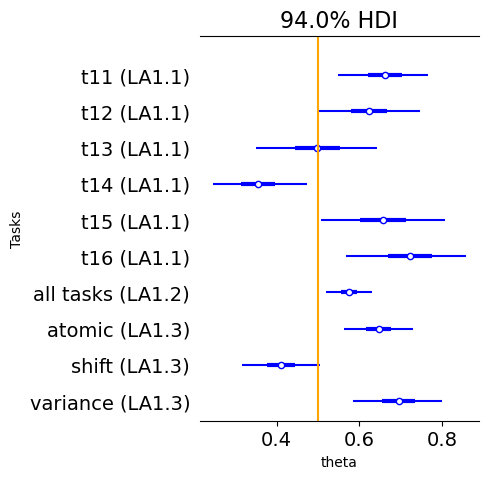

In [52]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_acc_T2_mco_m1_corr)
prob = 0.94
az.plot_forest(ai['posterior']['theta'], ax = ax, combined = True, hdi_prob = prob, colors = 'blue')
ax.vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['variance (LA1.3)','shift (LA1.3)','atomic (LA1.3)','all tasks (LA1.2)','t16 (LA1.1)','t15 (LA1.1)','t14 (LA1.1)','t13 (LA1.1)','t12 (LA1.1)','t11 (LA1.1)'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("theta")
plt.savefig('ch6_Fig11_e.svg',dpi=300)

## Multiple Correct Options (MCO) LA2 

Takes **only** participants who got the model correct together based on visualization condition.

Accuracy: 

0  If hamming score = 0 (0 digits in the digital representations of correct answer and participant's response are similar)

1  If hamming score = 1

2  If hamming score = 2

In [9]:
## number of trials (available options) per task in TT1
n_i = [3
       for t,value in answ_sc_i_interv_corr_mod_T2.items() 
       for j in value]
n_s = [3
       for t,value in answ_sc_s_interv_corr_mod_T2.items() 
       for j in value]
n_a = [3
       for t,value in answ_sc_a_interv_corr_mod_T2.items() 
       for j in value]
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_interv_corr_mod_T2.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_interv_corr_mod_T2.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_interv_corr_mod_T2.items() 
         for j in value]
## indices 
t_indices_i = [t_ids['T2'].index(t) 
               for t,value in answ_sc_i_interv_corr_mod_T2.items() 
               for j in value]
t_indices_s = [t_ids['T2'].index(t) 
               for t,value in answ_sc_s_interv_corr_mod_T2.items() 
               for j in value]
t_indices_a = [t_ids['T2'].index(t) 
               for t,value in answ_sc_a_interv_corr_mod_T2.items() 
               for j in value]
## extension for 'all'
for i in range(len(n_i)):
    n_i.append(3)
for i in range(len(n_s)):
    n_s.append(3)
for i in range(len(n_a)):
    n_a.append(3)
#
for t,value in answ_sc_i_interv_corr_mod_T2.items():
    for j in value:
        t_indices_i.append(6)
for t,value in answ_sc_s_interv_corr_mod_T2.items():
    for j in value:
        t_indices_s.append(6)
for t,value in answ_sc_a_interv_corr_mod_T2.items():
    for j in value:
        t_indices_a.append(6)
#
for _,value in answ_sc_i_interv_corr_mod_T2.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_interv_corr_mod_T2.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_interv_corr_mod_T2.items(): 
    for j in value:
        ans_a.append(j)
#
t_id = []
t_id.extend(t_ids['T2'])
t_id.append('all')
trace_acc_T2_mco_m2_corr, pp_acc_T2_mco_m2_corr = get_inference_MCO_LA2(ans_i, ans_s, ans_a,
                                                n_i, n_s, n_a, 
                                                t_indices_i, t_indices_s, t_indices_a,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


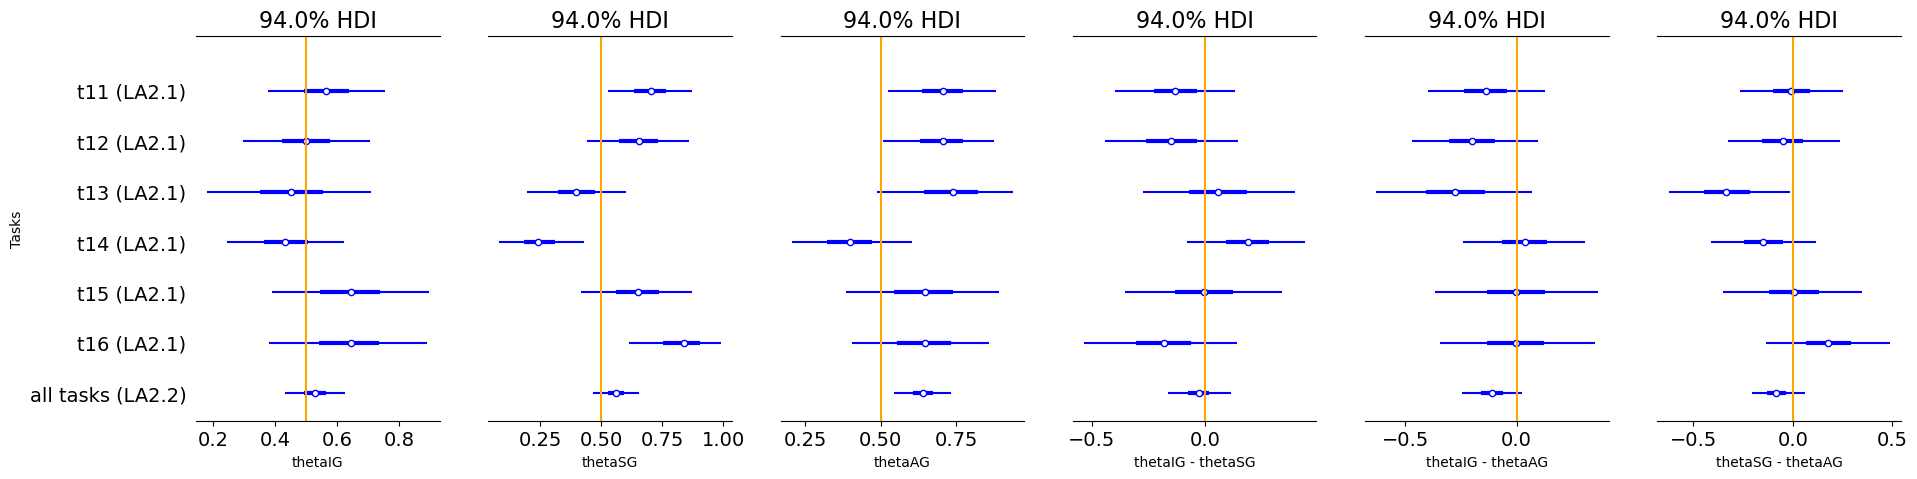

In [10]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T2_mco_m2_corr)
prob = 0.94
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True, hdi_prob = prob, colors = 'blue')
ax[0].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True, hdi_prob = prob, colors = 'blue')
ax[1].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True, hdi_prob = prob, colors = 'blue')
ax[2].vlines(x = 0.5, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True, hdi_prob = prob, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True, hdi_prob = prob, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True, hdi_prob = prob, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
ax[0].set_yticklabels(['all tasks (LA2.2)','t16 (LA2.1)','t15 (LA2.1)','t14 (LA2.1)','t13 (LA2.1)','t12 (LA2.1)','t11 (LA2.1)'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("thetaIG - thetaSG")
ax[4].set_xlabel("thetaIG - thetaAG")
ax[5].set_xlabel("thetaSG - thetaAG")
plt.savefig('ch6_Fig11_f.svg',dpi=300)

## Response Times LA1

In [4]:
## 
t_id = []
t_id.extend(t_ids['T1'])
t_id.extend(t_ids['T2'])
t_id.append('all tasks TT1')
t_id.append('all tasks TT2')
##
tim_i = [j for tt in times_i for _,value in times_i[tt].items() for j in value]
tim_s = [j for tt in times_s for _,value in  times_s[tt].items() for j in value]
tim_a = [j for tt in times_a for _,value in  times_a[tt].items() for j in value]
tim = tim_i+tim_s+tim_a
## indices
t_indices_i = [t_id.index(t) 
               for tt in times_i
               for t,value in times_i[tt].items() 
               for j in value]
t_indices_s = [t_id.index(t) 
               for tt in times_s
               for t,value in times_s[tt].items() 
               for j in value]
t_indices_a = [t_id.index(t) 
               for tt in times_a
               for t,value in times_a[tt].items() 
               for j in value]
t_indices = t_indices_i+t_indices_s+t_indices_a
## extension for "all TT1"
for tt in times_i:
    if tt == 'T1':
        for _,value in times_i[tt].items():
            for j in value:
                tim.append(j)
for tt in times_s:
    if tt == 'T1':
        for _,value in times_s[tt].items():
            for j in value:
                tim.append(j)
for tt in times_a:
    if tt == 'T1':
        for _,value in times_a[tt].items():
            for j in value:
                tim.append(j)
## indices
for tt in times_i:
    if tt == 'T1':
        for t,value in times_i[tt].items():
            for j in value:
                t_indices.append(16)
for tt in times_s:
    if tt == 'T1':
        for t,value in times_s[tt].items():
            for j in value:
                t_indices.append(16)
for tt in times_a:
    if tt == 'T1':
        for t,value in times_a[tt].items():
            for j in value:
                t_indices.append(16)
## extension for "all TT2"
for tt in times_i:
    if tt == 'T2':
        for _,value in times_i[tt].items():
            for j in value:
                tim.append(j)
for tt in times_s:
    if tt == 'T2':
        for _,value in times_s[tt].items():
            for j in value:
                tim.append(j)
for tt in times_a:
    if tt == 'T2':
        for _,value in times_a[tt].items():
            for j in value:
                tim.append(j)
## indices
for tt in times_i:
    if tt == 'T2':
        for t,value in times_i[tt].items():
            for j in value:
                t_indices.append(17)
for tt in times_s:
    if tt == 'T2':
        for t,value in times_s[tt].items():
            for j in value:
                t_indices.append(17)
for tt in times_a:
    if tt == 'T2':
        for t,value in times_a[tt].items():
            for j in value:
                t_indices.append(17)

trace_rt_la1, pp_rt_la1 = get_times_inference_LA1(tim, 
                                              t_indices,
                                              t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 27 seconds.


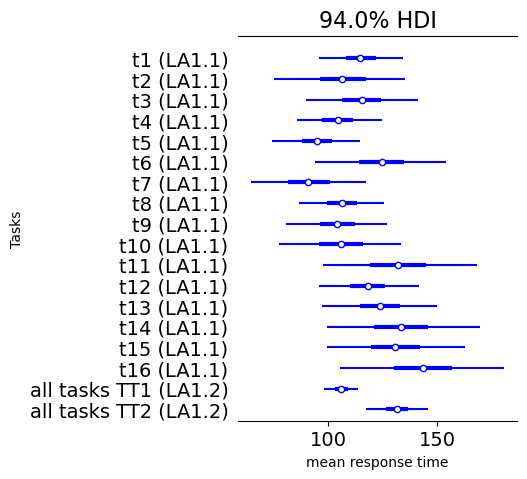

In [5]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_rt_la1)

az.plot_forest(ai['posterior']['group_mean'], ax = ax, combined = True, colors = 'blue')
# ax.vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['all tasks TT2 (LA1.2)','all tasks TT1 (LA1.2)','t16 (LA1.1)','t15 (LA1.1)','t14 (LA1.1)','t13 (LA1.1)','t12 (LA1.1)','t11 (LA1.1)','t10 (LA1.1)','t9 (LA1.1)','t8 (LA1.1)','t7 (LA1.1)','t6 (LA1.1)','t5 (LA1.1)','t4 (LA1.1)','t3 (LA1.1)','t2 (LA1.1)','t1 (LA1.1)'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("mean response time")
plt.savefig('ch6_Fig12_a.svg',dpi=300)

## Response Times LA2

In [9]:
## 
t_id = []
t_id.extend(t_ids['T1'])
t_id.extend(t_ids['T2'])
t_id.append('all tasks TT1')
t_id.append('all tasks TT2')
##
tim_i = [j for tt in times_i for _,value in times_i[tt].items() for j in value]
tim_s = [j for tt in times_s for _,value in  times_s[tt].items() for j in value]
tim_a = [j for tt in times_a for _,value in  times_a[tt].items() for j in value]
## indices
t_indices_i = [t_id.index(t) 
               for tt in times_i
               for t,value in times_i[tt].items() 
               for j in value]
t_indices_s = [t_id.index(t) 
               for tt in times_s
               for t,value in times_s[tt].items() 
               for j in value]
t_indices_a = [t_id.index(t) 
               for tt in times_a
               for t,value in times_a[tt].items() 
               for j in value]
## extension for "TT1"
for tt in times_i:
    if tt == 'T1':
        for _,value in times_i[tt].items():
            for j in value:
                tim_i.append(j)
for tt in times_s:
    if tt == 'T1':
        for _,value in times_s[tt].items():
            for j in value:
                tim_s.append(j)
for tt in times_a:
    if tt == 'T1':
        for _,value in times_a[tt].items():
            for j in value:
                tim_a.append(j)
## indices
for tt in times_i:
    if tt == 'T1':
        for t,value in times_i[tt].items():
            for j in value:
                t_indices_i.append(16)
for tt in times_s:
    if tt == 'T1':
        for t,value in times_s[tt].items():
            for j in value:
                t_indices_s.append(16)
for tt in times_a:
    if tt == 'T1':
        for t,value in times_a[tt].items():
            for j in value:
                t_indices_a.append(16)
## extension for "TT2"
for tt in times_i:
    if tt == 'T2':
        for _,value in times_i[tt].items():
            for j in value:
                tim_i.append(j)
for tt in times_s:
    if tt == 'T2':
        for _,value in times_s[tt].items():
            for j in value:
                tim_s.append(j)
for tt in times_a:
    if tt == 'T2':
        for _,value in times_a[tt].items():
            for j in value:
                tim_a.append(j)
## indices
for tt in times_i:
    if tt == 'T2':
        for t,value in times_i[tt].items():
            for j in value:
                t_indices_i.append(17)
for tt in times_s:
    if tt == 'T2':
        for t,value in times_s[tt].items():
            for j in value:
                t_indices_s.append(17)
for tt in times_a:
    if tt == 'T2':
        for t,value in times_a[tt].items():
            for j in value:
                t_indices_a.append(17)

trace_rt_la2, pp_rt_la2 = get_times_inference_LA2(tim_i, tim_s, tim_a, 
                                              t_indices_i, t_indices_s, t_indices_a,
                                              t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupAG_std, groupAG_mean, groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


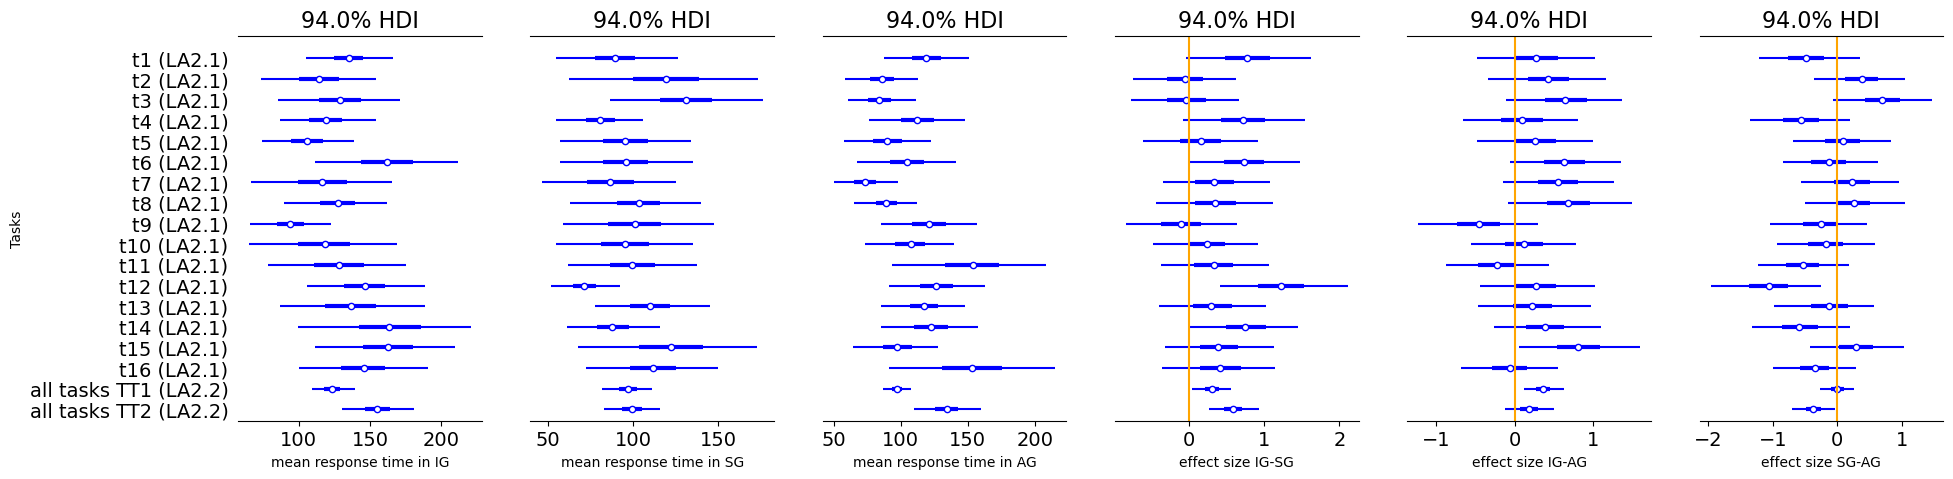

In [10]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_rt_la2)

az.plot_forest(ai['posterior']['groupIG_mean'], ax = ax[0], combined = True, colors = 'blue')
# ax[0].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['groupSG_mean'], ax = ax[1], combined = True, colors = 'blue')
# ax[1].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['groupAG_mean'], ax = ax[2], combined = True, colors = 'blue')
# ax[2].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

az.plot_forest(ai['posterior']['effect size IG-SG'], ax = ax[3], combined = True, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['effect size IG-AG'], ax = ax[4], combined = True, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['effect size SG-AG'], ax = ax[5], combined = True, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
##
ax[0].set_yticklabels(['all tasks TT2 (LA2.2)','all tasks TT1 (LA2.2)','t16 (LA2.1)','t15 (LA2.1)','t14 (LA2.1)','t13 (LA2.1)','t12 (LA2.1)','t11 (LA2.1)','t10 (LA2.1)','t9 (LA2.1)','t8 (LA2.1)','t7 (LA2.1)','t6 (LA2.1)','t5 (LA2.1)','t4 (LA2.1)','t3 (LA2.1)','t2 (LA2.1)','t1 (LA2.1)'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("mean response time in IG")
ax[1].set_xlabel("mean response time in SG")
ax[2].set_xlabel("mean response time in AG")
ax[3].set_xlabel("effect size IG-SG")
ax[4].set_xlabel("effect size IG-AG")
ax[5].set_xlabel("effect size SG-AG")
plt.savefig('ch6_Fig12_b.svg',dpi=300)

## Confidence - LA1

In [11]:
##
t_id = []
t_id.extend(t_ids['T1'])
t_id.extend(t_ids['T2'])
t_id.append('all tasks TT1')
t_id.append('all tasks TT2')
##
c_i = [j for tt in conf_i for _,value in conf_i[tt].items() 
       for j in value]
c_s = [j for tt in conf_s for _,value in conf_s[tt].items() 
       for j in value]
c_a = [j for tt in conf_a for _,value in conf_a[tt].items() 
       for j in value]
c = c_i+c_s+c_a
## indices
t_indices_i = [t_id.index(t) 
               for tt in conf_i
               for t,value in conf_i[tt].items() 
               for j in value]
t_indices_s = [t_id.index(t) 
               for tt in conf_s
               for t,value in conf_s[tt].items() 
               for j in value]
t_indices_a = [t_id.index(t) 
               for tt in conf_a
               for t,value in conf_a[tt].items() 
               for j in value]
t_indices = t_indices_i+t_indices_s+t_indices_a
## extension for 'TT1'
for tt in conf_i:
    if tt == 'T1':
        for _,value in conf_i[tt].items():
            for j in value:
                c.append(j)
for tt in conf_s:
    if tt == 'T1':
        for _,value in conf_s[tt].items():
            for j in value:
                c.append(j)
for tt in conf_a:
    if tt == 'T1':
        for _,value in conf_a[tt].items():
            for j in value:
                c.append(j)
## indices
for tt in conf_i:
    if tt == 'T1':
        for t,value in conf_i[tt].items():
            for j in value:
                t_indices.append(16)
for tt in conf_s:
    if tt == 'T1':
        for t,value in conf_s[tt].items():
            for j in value:
                t_indices.append(16)
for tt in conf_a:
    if tt == 'T1':
        for t,value in conf_a[tt].items():
            for j in value:
                t_indices.append(16)
## extension for 'TT2'
for tt in conf_i:
    if tt == 'T2':
        for _,value in conf_i[tt].items():
            for j in value:
                c.append(j)
for tt in conf_s:
    if tt == 'T2':
        for _,value in conf_s[tt].items():
            for j in value:
                c.append(j)
for tt in conf_a:
    if tt == 'T2':
        for _,value in conf_a[tt].items():
            for j in value:
                c.append(j)
## indices
for tt in conf_i:
    if tt == 'T2':
        for t,value in conf_i[tt].items():
            for j in value:
                t_indices.append(17)
for tt in conf_s:
    if tt == 'T2':
        for t,value in conf_s[tt].items():
            for j in value:
                t_indices.append(17)
for tt in conf_a:
    if tt == 'T2':
        for t,value in conf_a[tt].items():
            for j in value:
                t_indices.append(17)            
##
trace_conf_la1, pp_conf = get_confidence_inference_LA1(c,
                                                    t_indices, 
                                                    t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 26 seconds.


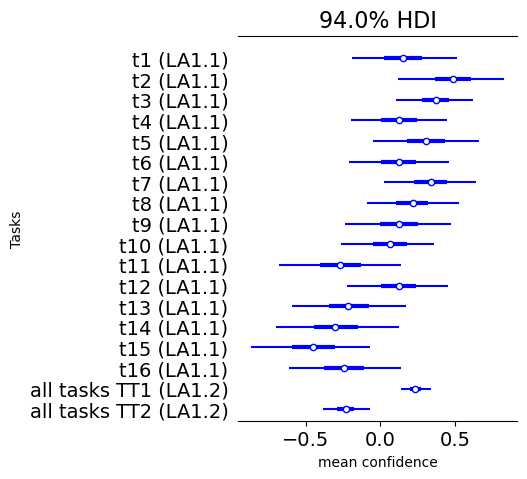

In [13]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(3.6, 5))
ai = az.from_pymc3(trace_conf_la1)

az.plot_forest(ai['posterior']['group_mean'], ax = ax, combined = True, colors = 'blue')
# ax.vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
ax.set_yticklabels(['all tasks TT2 (LA1.2)','all tasks TT1 (LA1.2)','t16 (LA1.1)','t15 (LA1.1)','t14 (LA1.1)','t13 (LA1.1)','t12 (LA1.1)','t11 (LA1.1)','t10 (LA1.1)','t9 (LA1.1)','t8 (LA1.1)','t7 (LA1.1)','t6 (LA1.1)','t5 (LA1.1)','t4 (LA1.1)','t3 (LA1.1)','t2 (LA1.1)','t1 (LA1.1)'])
ax.set_ylabel("Tasks")
##
ax.set_xlabel("mean confidence")
plt.savefig('ch6_Fig12_c.svg',dpi=300)

## Confidence - LA2

In [14]:
##
t_id = []
t_id.extend(t_ids['T1'])
t_id.extend(t_ids['T2'])
t_id.append('all tasks TT1')
t_id.append('all tasks TT2')
##
c_i = [j for tt in conf_i for _,value in conf_i[tt].items() 
       for j in value]
c_s = [j for tt in conf_s for _,value in conf_s[tt].items() 
       for j in value]
c_a = [j for tt in conf_a for _,value in conf_a[tt].items() 
       for j in value]
## indices
t_indices_i = [t_id.index(t) 
               for tt in conf_i
               for t,value in conf_i[tt].items() 
               for j in value]
t_indices_s = [t_id.index(t) 
               for tt in conf_s
               for t,value in conf_s[tt].items() 
               for j in value]
t_indices_a = [t_id.index(t) 
               for tt in conf_a
               for t,value in conf_a[tt].items() 
               for j in value]
## extension for 'TT1'
for tt in conf_i:
    if tt == 'T1':
        for _,value in conf_i[tt].items():
            for j in value:
                c_i.append(j)
for tt in conf_s:
    if tt == 'T1':
        for _,value in conf_s[tt].items():
            for j in value:
                c_s.append(j)
for tt in conf_a:
    if tt == 'T1':
        for _,value in conf_a[tt].items():
            for j in value:
                c_a.append(j)
## indices
for tt in conf_i:
    if tt == 'T1':
        for t,value in conf_i[tt].items():
            for j in value:
                t_indices_i.append(16)
for tt in conf_s:
    if tt == 'T1':
        for t,value in conf_s[tt].items():
            for j in value:
                t_indices_s.append(16)
for tt in conf_a:
    if tt == 'T1':
        for t,value in conf_a[tt].items():
            for j in value:
                t_indices_a.append(16)
## extension for 'TT2'
for tt in conf_i:
    if tt == 'T2':
        for _,value in conf_i[tt].items():
            for j in value:
                c_i.append(j)
for tt in conf_s:
    if tt == 'T2':
        for _,value in conf_s[tt].items():
            for j in value:
                c_s.append(j)
for tt in conf_a:
    if tt == 'T2':
        for _,value in conf_a[tt].items():
            for j in value:
                c_a.append(j)
## indices
for tt in conf_i:
    if tt == 'T2':
        for t,value in conf_i[tt].items():
            for j in value:
                t_indices_i.append(17)
for tt in conf_s:
    if tt == 'T2':
        for t,value in conf_s[tt].items():
            for j in value:
                t_indices_s.append(17)
for tt in conf_a:
    if tt == 'T2':
        for t,value in conf_a[tt].items():
            for j in value:
                t_indices_a.append(17)
            
##
trace_conf_la2, pp_conf = get_confidence_inference_LA2(c_i, c_s, c_a,
                                                       t_indices_i, t_indices_s, t_indices_a, 
                                                       t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [groupAG_std, groupAG_mean, groupSG_std, groupSG_mean, groupIG_std, groupIG_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 29 seconds.


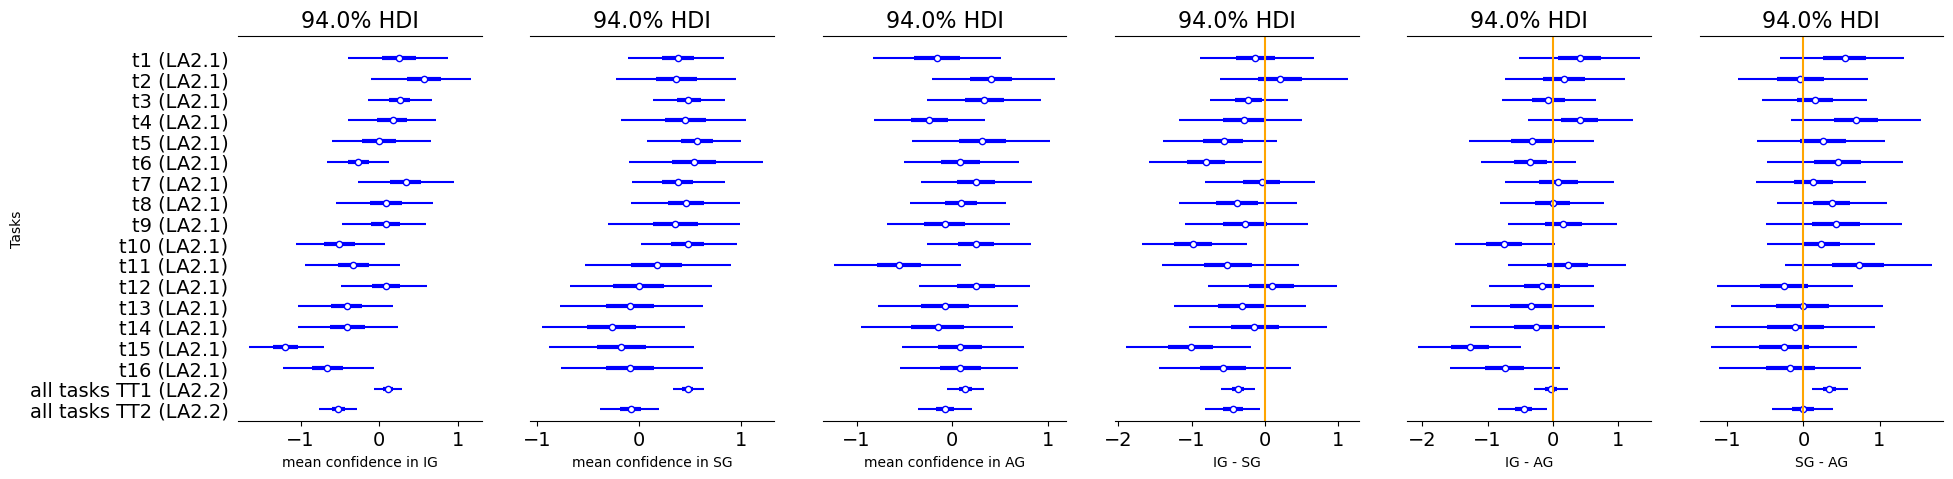

In [15]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_conf_la2)

az.plot_forest(ai['posterior']['groupIG_mean'], ax = ax[0], combined = True, colors = 'blue')
# ax[0].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['groupSG_mean'], ax = ax[1], combined = True, colors = 'blue')
# ax[1].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['groupAG_mean'], ax = ax[2], combined = True, colors = 'blue')
# ax[2].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

az.plot_forest(ai['posterior']['difference of means IG-SG'], ax = ax[3], combined = True, colors = 'blue')
ax[3].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of means IG-AG'], ax = ax[4], combined = True, colors = 'blue')
ax[4].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of means SG-AG'], ax = ax[5], combined = True, colors = 'blue')
ax[5].vlines(x = 0, ymin = -1, ymax = 15, colors = 'orange')

##
ax[0].set_yticklabels(['all tasks TT2 (LA2.2)','all tasks TT1 (LA2.2)','t16 (LA2.1)','t15 (LA2.1)','t14 (LA2.1)','t13 (LA2.1)','t12 (LA2.1)','t11 (LA2.1)','t10 (LA2.1)','t9 (LA2.1)','t8 (LA2.1)','t7 (LA2.1)','t6 (LA2.1)','t5 (LA2.1)','t4 (LA2.1)','t3 (LA2.1)','t2 (LA2.1)','t1 (LA2.1)'])
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("mean confidence in IG")
ax[1].set_xlabel("mean confidence in SG")
ax[2].set_xlabel("mean confidence in AG")
ax[3].set_xlabel("IG - SG")
ax[4].set_xlabel("IG - AG")
ax[5].set_xlabel("SG - AG")
plt.savefig('ch6_Fig12_d.svg',dpi=300)

## Analysis 3 - Correcting Accuracy by Confidence
Acc: 

0  If hamming distance = 0 

1  If hamming distance = 1

2  If hamming distance = 2

Correct theta by confidence

In [4]:
## number of trials (available options) per task in TT1
n_i = [2
       for t,value in answ_sc_i_multi.items() 
       for j in value]
n_s = [2
       for t,value in answ_sc_s_multi.items() 
       for j in value]
n_a = [2
       for t,value in answ_sc_a_multi.items() 
       for j in value]
## interactive, static, animated answers
ans_i = [j for _,value in answ_sc_i_multi.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_multi.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_multi.items() 
         for j in value]
c_i = [j for _,value in conf_i['T1'].items() 
         for j in value]
c_s = [j for _,value in conf_s['T1'].items() 
         for j in value]
c_a = [j for _,value in conf_a['T1'].items() 
         for j in value]
## indices 
t_indices_i = [t_ids['T1'].index(t) 
               for t,value in answ_sc_i_multi.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t) 
               for t,value in answ_sc_s_multi.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_multi.items() 
               for j in value]
## extension for 'all'
for i in range(len(n_i)):
    n_i.append(2)
for i in range(len(n_s)):
    n_s.append(2)
for i in range(len(n_a)):
    n_a.append(2)
#
for t,value in answ_sc_i_multi.items():
    for j in value:
        t_indices_i.append(10)
for t,value in answ_sc_s_multi.items():
    for j in value:
        t_indices_s.append(10)
for t,value in answ_sc_a_multi.items():
    for j in value:
        t_indices_a.append(10)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans_a.append(j)
for _,value in conf_i['T1'].items(): 
    for j in value:
        c_i.append(j)
for _,value in conf_s['T1'].items():
    for j in value:
        c_s.append(j)
for _,value in conf_a['T1'].items(): 
    for j in value:
        c_a.append(j)
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
trace_acc_T1_multi_conf, pp_acc_T1_multi_conf = get_inference_multi_conf(ans_i, ans_s, ans_a, c_i, c_s, c_a,
                                                n_i, n_s, n_a, 
                                                t_indices_i, t_indices_s, t_indices_a,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k1, k0, thetaAG, thetaSG, thetaIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.
There were 1828 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1920 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1708 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1890 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


Text(0.5, 0, 'SG-AG')

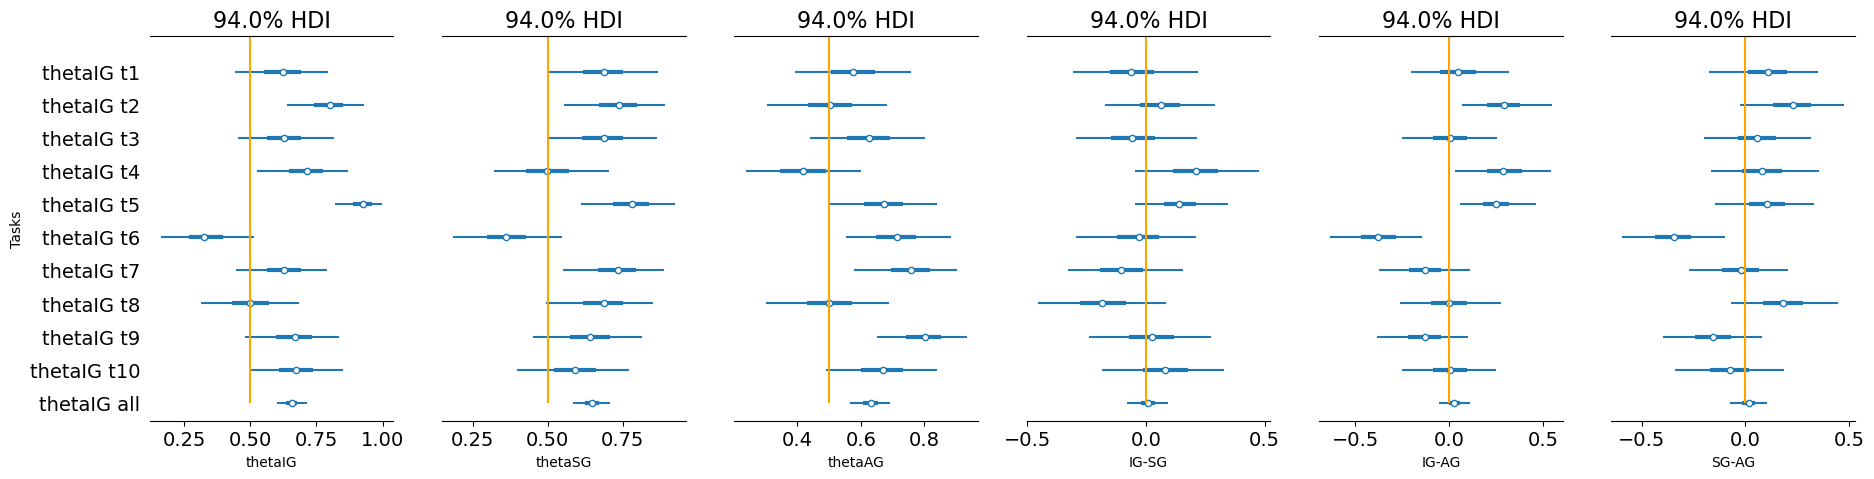

In [5]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T1_multi_conf)
# ai['posterior']
az.plot_forest(ai['posterior']['thetaIG'], ax = ax[0], combined = True)
ax[0].vlines(x = 0.5, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaSG'], ax = ax[1], combined = True)
ax[1].vlines(x = 0.5, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['thetaAG'], ax = ax[2], combined = True)
ax[2].vlines(x = 0.5, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True)
ax[3].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True)
ax[4].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')
az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True)
ax[5].vlines(x = 0, ymin = 0, ymax = 15, colors = 'orange')

##
# ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
ax[3].set_xlabel("IG-SG")
ax[4].set_xlabel("IG-AG")
ax[5].set_xlabel("SG-AG")

## Analysis 4 - Inference on the participant level
Acc: 

0  If hamming distance = 0 

1  If hamming distance = 1

2  If hamming distance = 2

Estimate theta per participant

In [11]:
## Analysis taking answers as a single option
# interactive, static, and animated answers
ans_i = [j for _,value in answ_sc_i_singl.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_singl.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_singl.items() 
         for j in value]
#indices 
t_indices_i = [i
               for t,value in answ_sc_i_singl.items() 
               for i,j in enumerate(value)]
num_p_i = len(answ_sc_i_singl['t1'])
t_indices_s = [i
               for t,value in answ_sc_s_singl.items() 
               for i,j in enumerate(value)]
num_p_s = len(answ_sc_s_singl['t1'])
t_indices_a = [i
               for t,value in answ_sc_a_singl.items() 
               for i,j in enumerate(value)]
num_p_a = len(answ_sc_a_singl['t1'])
##
t_id_i = []
for p in range(num_p_i):
    t_id_i.append('p'+str(p))
t_id_s = []
for p in range(num_p_s):
    t_id_s.append('p'+str(p+num_p_i))
t_id_a = []
for p in range(num_p_a):
    t_id_a.append('p'+str(p+num_p_i+num_p_s))
trace_acc_T1_singl_part_i, pp_acc_T1_singl_part_i = get_inference_sinlg_part(ans_i, t_indices_i, t_id_i)
trace_acc_T1_singl_part_s, pp_acc_T1_singl_part_s = get_inference_sinlg_part(ans_s, t_indices_s, t_id_s)
trace_acc_T1_singl_part_a, pp_acc_T1_singl_part_a = get_inference_sinlg_part(ans_a, t_indices_a, t_id_a)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 24 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 44 seconds.


Text(0.5, 0, 'thetaAG')

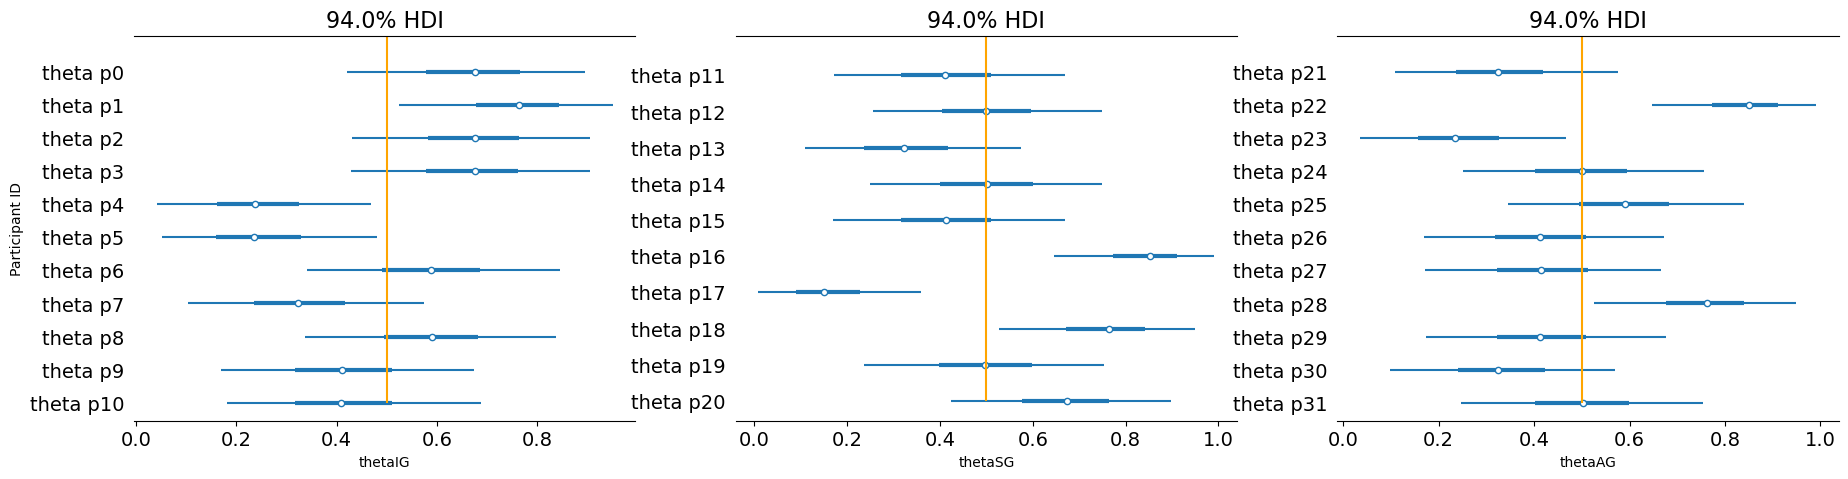

In [12]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(22, 5))
ai = az.from_pymc3(trace_acc_T1_singl_part_i)
a_s = az.from_pymc3(trace_acc_T1_singl_part_s)
aa = az.from_pymc3(trace_acc_T1_singl_part_a)
y_max = 11
# ai['posterior']
az.plot_forest(ai['posterior']['theta'], ax = ax[0], combined = True)
ax[0].vlines(x = 0.5, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(a_s['posterior']['theta'], ax = ax[1], combined = True)
ax[1].vlines(x = 0.5, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(aa['posterior']['theta'], ax = ax[2], combined = True)
ax[2].vlines(x = 0.5, ymin = 0, ymax = y_max, colors = 'orange')
# az.plot_forest(ai['posterior']['difference of thetas IG-SG'], ax = ax[3], combined = True)
# ax[3].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')
# az.plot_forest(ai['posterior']['difference of thetas IG-AG'], ax = ax[4], combined = True)
# ax[4].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')
# az.plot_forest(ai['posterior']['difference of thetas SG-AG'], ax = ax[5], combined = True)
# ax[5].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')

##
# ax[0].get_yaxis().set_visible(False)
# ax[1].get_yaxis().set_visible(False)
# ax[2].get_yaxis().set_visible(False)
# ax[3].get_yaxis().set_visible(False)
# ax[4].get_yaxis().set_visible(False)
# ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Participant ID")
##
ax[0].set_xlabel("thetaIG")
ax[1].set_xlabel("thetaSG")
ax[2].set_xlabel("thetaAG")
# ax[3].set_xlabel("IG-SG")
# ax[4].set_xlabel("IG-AG")
# ax[5].set_xlabel("SG-AG")

## Analysis 5 - Categorical Likelihood
Acc: 

0  If hamming distance = 0 

1  If hamming distance = 1

2  If hamming distance = 2


In [5]:
import pymc3 as pm
def get_inference_categ(answers_i, answers_s, answers_a, t_indices_i, t_indices_s, t_indices_a, t_ids):
    """
        answers_i: List of success for all tasks in rq1 for all interactive participants
        n:         List of trials size (number of available options) per task in rq1
        t_indices: List of indexes to rq1 tasks for all observations in answers_i or answers_s
        t_ids:     List of Strings with tasks ids
    """    
    coords = {"task": t_ids}
    with pm.Model(coords=coords) as model:
        #priors
        pIG = pm.Dirichlet("pIG", a=np.tile(np.array([0.5,0.5,0.5]),(14,1)))#probability of correct choice ti, 'all', 'atomic', 'shift', 'variance'
        pSG = pm.Dirichlet("pSG", a=np.tile(np.array([0.5,0.5,0.5]),(14,1)))
        pAG = pm.Dirichlet("pAG", a=np.tile(np.array([0.5,0.5,0.5]),(14,1)))

        #likelihood        
        accuracyIG = pm.Categorical("accuracyIG", p = pIG[t_indices_i], observed = answers_i)
        accuracySG = pm.Categorical("accuracySG", p = pSG[t_indices_s], observed = answers_s)
        accuracyAG = pm.Categorical("accuracyAG", p = pAG[t_indices_a], observed = answers_a)
        
        #comparisons
        # diff_of_thetas_IG_SG = pm.Deterministic("difference of thetas IG-SG", thetaIG - thetaSG, dims='task')
        # diff_of_thetas_IG_AG = pm.Deterministic("difference of thetas IG-AG", thetaIG - thetaAG, dims='task')
        # diff_of_thetas_SG_AG = pm.Deterministic("difference of thetas SG-AG", thetaSG - thetaAG, dims='task')
       
        #inference
        trace = pm.sample(2000)
        posterior_predictive = pm.sample_posterior_predictive(trace, samples=2000)
    return trace, posterior_predictive

## Responses of IG, SG, AG
ans_i = [j for _,value in answ_sc_i_multi.items() 
         for j in value]
ans_s = [j for _,value in answ_sc_s_multi.items() 
         for j in value]
ans_a = [j for _,value in answ_sc_a_multi.items() 
         for j in value]
## indices 
t_indices_i = [t_ids['T1'].index(t) 
               for t,value in answ_sc_i_multi.items() 
               for j in value]
t_indices_s = [t_ids['T1'].index(t) 
               for t,value in answ_sc_s_multi.items() 
               for j in value]
t_indices_a = [t_ids['T1'].index(t) 
               for t,value in answ_sc_a_multi.items() 
               for j in value]
## Extension for 'all'
for t,value in answ_sc_i_multi.items():
    for j in value:
        t_indices_i.append(10)
for t,value in answ_sc_s_multi.items():
    for j in value:
        t_indices_s.append(10)
for t,value in answ_sc_a_multi.items():
    for j in value:
        t_indices_a.append(10)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans_a.append(j)
## Extention for 'atomic', 'shift', 'variance'
t_atomic = ['t1','t2','t3','t4','t5']
t_shift = ['t6','t7']
t_variance = ['t8','t9','t10']
for t,value in answ_sc_i_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices_i.append(11)
        elif t in t_shift:
            t_indices_i.append(12)
        elif t in t_variance:
            t_indices_i.append(13)
for t,value in answ_sc_s_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices_s.append(11)
        elif t in t_shift:
            t_indices_s.append(12)
        elif t in t_variance:
            t_indices_s.append(13)
for t,value in answ_sc_a_multi.items():
    for j in value:
        if t in t_atomic:
            t_indices_a.append(11)
        elif t in t_shift:
            t_indices_a.append(12)
        elif t in t_variance:
            t_indices_a.append(13)
#
for _,value in answ_sc_i_multi.items(): 
    for j in value:
        ans_i.append(j)
for _,value in answ_sc_s_multi.items():
    for j in value:
        ans_s.append(j)
for _,value in answ_sc_a_multi.items(): 
    for j in value:
        ans_a.append(j)
## 
t_id = []
t_id.extend(t_ids['T1'])
t_id.append('all')
trace_acc_T1_multi_cat, pp_acc_T1_multi_cat = get_inference_categ(ans_i, ans_s, ans_a,
                                                t_indices_i, t_indices_s, t_indices_a,
                                                t_id)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pAG, pSG, pIG]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 71 seconds.


### Plot Forest Plot of Posterior Predictive Samples

In [23]:
pp_data = {'IG':{},'AG':{},'SG':{}}
pp_data['IG']['t1'] = pp_acc_T1_multi_cat['accuracyIG'][:,0:11].flatten()
pp_data['IG']['t2'] = pp_acc_T1_multi_cat['accuracyIG'][:,11:22].flatten()
pp_data['IG']['t3'] = pp_acc_T1_multi_cat['accuracyIG'][:,22:33].flatten()
pp_data['IG']['t4'] = pp_acc_T1_multi_cat['accuracyIG'][:,33:44].flatten()
pp_data['IG']['t5'] = pp_acc_T1_multi_cat['accuracyIG'][:,44:55].flatten()
pp_data['IG']['t6'] = pp_acc_T1_multi_cat['accuracyIG'][:,55:66].flatten()
pp_data['IG']['t7'] = pp_acc_T1_multi_cat['accuracyIG'][:,66:77].flatten()
pp_data['IG']['t8'] = pp_acc_T1_multi_cat['accuracyIG'][:,77:88].flatten()
pp_data['IG']['t9'] = pp_acc_T1_multi_cat['accuracyIG'][:,88:99].flatten()
pp_data['IG']['t10'] = pp_acc_T1_multi_cat['accuracyIG'][:,99:110].flatten()
pp_data['IG']['all'] = pp_acc_T1_multi_cat['accuracyIG'][:,110:220].flatten()
pp_data['IG']['atomic'] = pp_acc_T1_multi_cat['accuracyIG'][:,220:275].flatten()
pp_data['IG']['shift'] = pp_acc_T1_multi_cat['accuracyIG'][:,275:297].flatten()
pp_data['IG']['variance'] = pp_acc_T1_multi_cat['accuracyIG'][:,297:330].flatten()
pp_data['SG']['t1'] = pp_acc_T1_multi_cat['accuracySG'][:,0:10].flatten()
pp_data['SG']['t2'] = pp_acc_T1_multi_cat['accuracySG'][:,10:20].flatten()
pp_data['SG']['t3'] = pp_acc_T1_multi_cat['accuracySG'][:,20:30].flatten()
pp_data['SG']['t4'] = pp_acc_T1_multi_cat['accuracySG'][:,30:40].flatten()
pp_data['SG']['t5'] = pp_acc_T1_multi_cat['accuracySG'][:,40:50].flatten()
pp_data['SG']['t6'] = pp_acc_T1_multi_cat['accuracySG'][:,50:60].flatten()
pp_data['SG']['t7'] = pp_acc_T1_multi_cat['accuracySG'][:,60:70].flatten()
pp_data['SG']['t8'] = pp_acc_T1_multi_cat['accuracySG'][:,70:80].flatten()
pp_data['SG']['t9'] = pp_acc_T1_multi_cat['accuracySG'][:,80:90].flatten()
pp_data['SG']['t10'] = pp_acc_T1_multi_cat['accuracySG'][:,90:100].flatten()
pp_data['SG']['all'] = pp_acc_T1_multi_cat['accuracySG'][:,100:200].flatten()
pp_data['SG']['atomic'] = pp_acc_T1_multi_cat['accuracySG'][:,200:250].flatten()
pp_data['SG']['shift'] = pp_acc_T1_multi_cat['accuracySG'][:,250:270].flatten()
pp_data['SG']['variance'] = pp_acc_T1_multi_cat['accuracySG'][:,270:300].flatten()
pp_data['AG']['t1'] = pp_acc_T1_multi_cat['accuracyAG'][:,0:11].flatten()
pp_data['AG']['t2'] = pp_acc_T1_multi_cat['accuracyAG'][:,11:22].flatten()
pp_data['AG']['t3'] = pp_acc_T1_multi_cat['accuracyAG'][:,22:33].flatten()
pp_data['AG']['t4'] = pp_acc_T1_multi_cat['accuracyAG'][:,33:44].flatten()
pp_data['AG']['t5'] = pp_acc_T1_multi_cat['accuracyAG'][:,44:55].flatten()
pp_data['AG']['t6'] = pp_acc_T1_multi_cat['accuracyAG'][:,55:66].flatten()
pp_data['AG']['t7'] = pp_acc_T1_multi_cat['accuracyAG'][:,66:77].flatten()
pp_data['AG']['t8'] = pp_acc_T1_multi_cat['accuracyAG'][:,77:88].flatten()
pp_data['AG']['t9'] = pp_acc_T1_multi_cat['accuracyAG'][:,88:99].flatten()
pp_data['AG']['t10'] = pp_acc_T1_multi_cat['accuracyAG'][:,99:110].flatten()
pp_data['AG']['all'] = pp_acc_T1_multi_cat['accuracyAG'][:,110:220].flatten()
pp_data['AG']['atomic'] = pp_acc_T1_multi_cat['accuracyAG'][:,220:275].flatten()
pp_data['AG']['shift'] = pp_acc_T1_multi_cat['accuracyAG'][:,275:297].flatten()
pp_data['AG']['variance'] = pp_acc_T1_multi_cat['accuracyAG'][:,297:330].flatten()
# import arviz as az
# xarray_IG = az.convert_to_dataset(pp_data['IG']) 
# xarray_SG = az.convert_to_dataset(pp_data['SG']) 
# xarray_AG = az.convert_to_dataset(pp_data['AG']) 
# data_pp = az.convert_to_inference_data(xarray_IG, group = 'IG')
# data_pp.add_groups({'SG':xarray_SG,'AG':xarray_AG})
# data_pp
pp_data['AG']['all'].std()

0.7951762582171522

Text(0.5, 0, 'pAG Hamm. = 0')

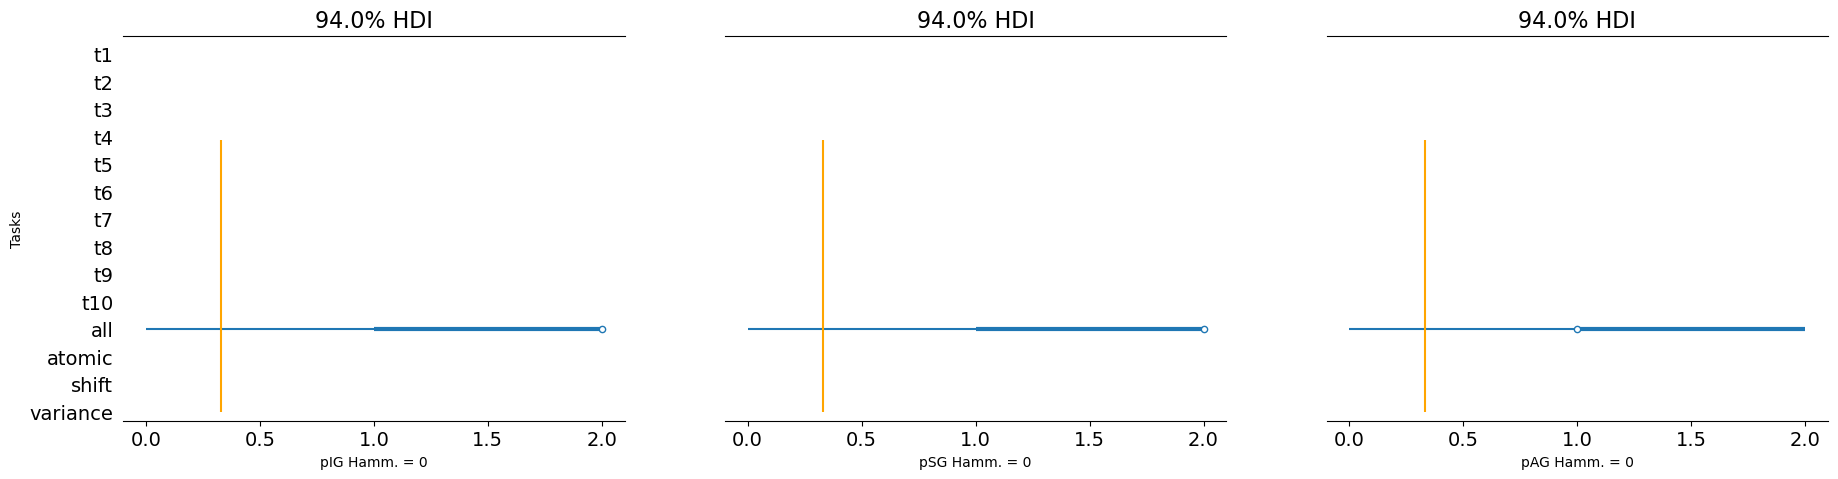

In [19]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(22, 5))

# ai['posterior']
y_max = 40
az.plot_forest(data_pp['IG'], ax = ax[0], combined = True)
ax[0].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pp['SG'], ax = ax[1], combined = True)
ax[1].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pp['AG'], ax = ax[2], combined = True)
ax[2].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')

##
# ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("pIG Hamm. = 0")
ax[1].set_xlabel("pSG Hamm. = 0")
ax[2].set_xlabel("pAG Hamm. = 0")

### Plot Error Bars

In [29]:
import pandas as pd
data_categ = {'condition':[], 'accuracy':[], 'task':[]}
for group in pp_data:
    for t in pp_data[group]:
        for v in pp_data[group][t]:
            data_categ['condition'].append(group)
            data_categ['task'].append(t)
            data_categ['accuracy'].append(v)
df = pd.DataFrame(data_categ)

<AxesSubplot: xlabel='accuracy', ylabel='task'>

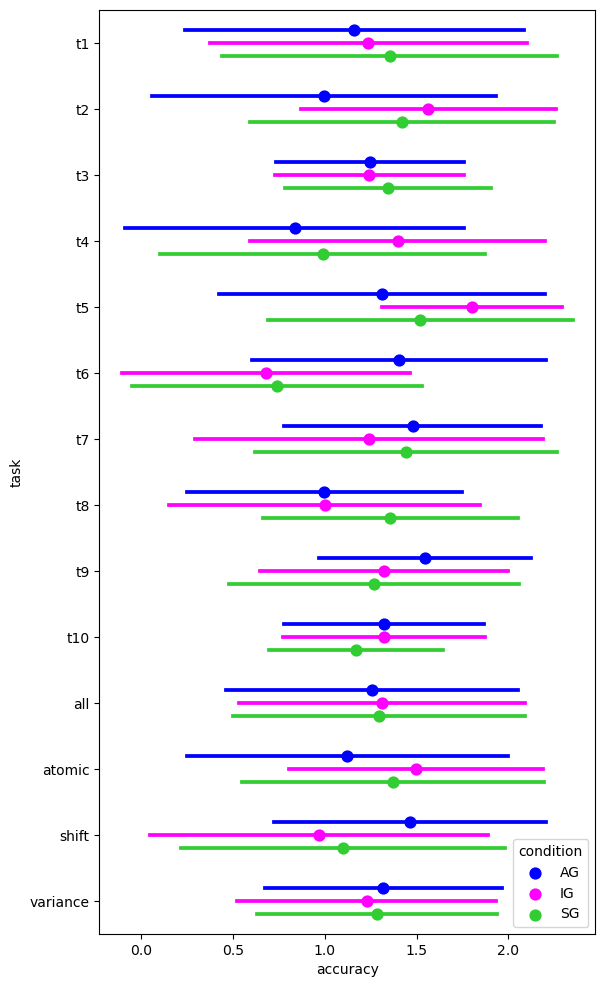

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure().set_figheight(12)
p = {'AG':'blue','IG':'magenta','SG':'#32CD32'}
sns.pointplot(df, x = 'accuracy', y='task', hue = 'condition', join=False, errorbar = 'sd', palette = p, hue_order = ['AG','IG','SG'], dodge = 0.4)

### Plot Posterior Predictive Distributions

In [46]:
import pandas as pd
pp_acc_T1_multi_cat['accuracyIG']#[:,0:110][0]
# pp_acc_T1_multi_cat
# d_cat = az.from_pymc3(trace_acc_T1_multi_cat, posterior_predictive = pp_acc_T1_multi_cat)
d_cat
data_categ = {'condition':[], 'accuracy':[]}
for i in pp_acc_T1_multi_cat['accuracyIG'].flatten():
    data_categ['condition'].append('i')
    data_categ['accuracy'].append(str(i))
    data_categ['condition'].append('all')
    data_categ['accuracy'].append(str(i))
for i in pp_acc_T1_multi_cat['accuracySG'].flatten():
    data_categ['condition'].append('s')
    data_categ['accuracy'].append(str(i))
    data_categ['condition'].append('all')
    data_categ['accuracy'].append(str(i))
for i in pp_acc_T1_multi_cat['accuracyAG'].flatten():
    data_categ['condition'].append('a')
    data_categ['accuracy'].append(str(i))
    data_categ['condition'].append('all')
    data_categ['accuracy'].append(str(i))

df = pd.DataFrame(data_categ)

<AxesSubplot: xlabel='accuracy', ylabel='Probability'>

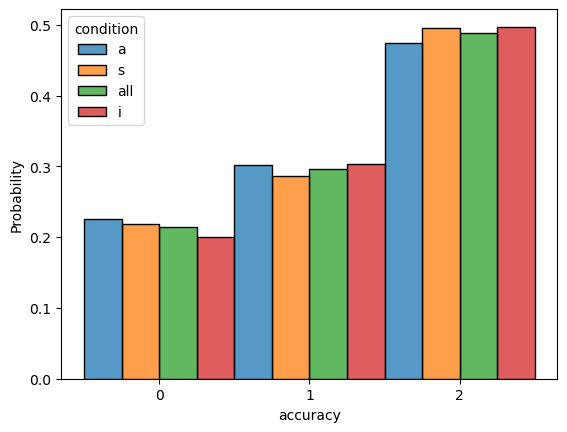

In [56]:
sns.histplot(df.sort_values(['accuracy']),stat='probability',x="accuracy",hue='condition',common_norm = False,multiple="dodge")

### Plot Categorical p

In [9]:
import arviz as az
## posterior pred
pp_reshape = pp_acc_T1_multi_cat['accuracyIG'][:,0:110].reshape(2000,10,11)
pp_reoredered = {}
for t in t_ids['T1']:
    t_i = t_ids['T1'].index(t)
    pp_reoredered[t] = pp_reshape[:,t_i,:].flatten()
data_pp = az.convert_to_dataset(pp_reoredered) 
# az.plot_forest(trace_acc_T1_multi_cat, combined = True)
## posterior p
hamm = 2
pIG_reoredered = {}
for t in t_ids['T1']:
    t_i = t_ids['T1'].index(t)
    pIG_reoredered[t] = trace_acc_T1_multi_cat['pIG'][:,t_i,hamm].flatten()
data_pIG = az.convert_to_dataset(pIG_reoredered) 

pSG_reoredered = {}
for t in t_ids['T1']:
    t_i = t_ids['T1'].index(t)
    pSG_reoredered[t] = trace_acc_T1_multi_cat['pSG'][:,t_i,hamm].flatten()
data_pSG = az.convert_to_dataset(pSG_reoredered) 


pAG_reoredered = {}
for t in t_ids['T1']:
    t_i = t_ids['T1'].index(t)
    pAG_reoredered[t] = trace_acc_T1_multi_cat['pAG'][:,t_i,hamm].flatten()
data_pAG = az.convert_to_dataset(pAG_reoredered) 


Text(0.5, 0, 'SG-AG')

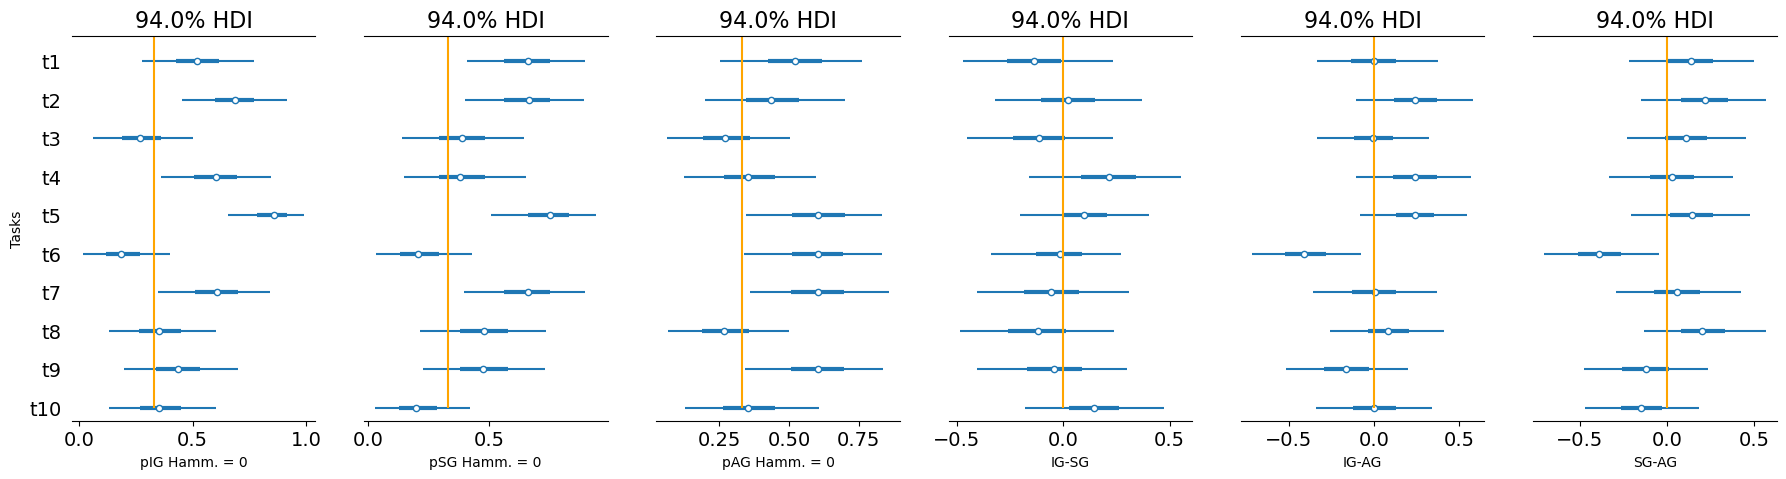

In [10]:
import arviz as az
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(22, 5))
# ai = az.from_pymc3(trace_acc_T2_singl)
# ai['posterior']
y_max = 40
az.plot_forest(data_pIG, ax = ax[0], combined = True)
ax[0].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pSG, ax = ax[1], combined = True)
ax[1].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pAG, ax = ax[2], combined = True)
ax[2].vlines(x = 0.33, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pIG-data_pSG, ax = ax[3], combined = True)
ax[3].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pIG-data_pAG, ax = ax[4], combined = True)
ax[4].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')
az.plot_forest(data_pSG-data_pAG, ax = ax[5], combined = True)
ax[5].vlines(x = 0, ymin = 0, ymax = y_max, colors = 'orange')

##
# ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)
ax[4].get_yaxis().set_visible(False)
ax[5].get_yaxis().set_visible(False)
ax[0].set_ylabel("Tasks")
##
ax[0].set_xlabel("pIG Hamm. = 0")
ax[1].set_xlabel("pSG Hamm. = 0")
ax[2].set_xlabel("pAG Hamm. = 0")
ax[3].set_xlabel("IG-SG")
ax[4].set_xlabel("IG-AG")
ax[5].set_xlabel("SG-AG")